In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
data = pd.read_csv('./data/AT.dat', delimiter="\t",
                   skiprows=[0], names=["k","r","x","A[k,r,x]"])
print(data.head())
data = data.to_numpy()

# Use first 8,056 points as training/validation and rest as test set.
train_data = data[0:8056]
test_data = data[8056:]

       k         r         x  A[k,r,x]
0  0.001  0.010817 -0.973907  1.009217
1  0.001  0.010817 -0.679410  1.009143
2  0.001  0.010817 -0.148874  1.009077
3  0.001  0.010817  0.148874  1.009077
4  0.001  0.010817  0.679410  1.009142


### Implementation

We will use wind power forecast data, which is available at the following link. It consists of normalized (between zero and one) wind power measurements from seven wind farms. To keep things simple, we will use first wind farm data (column named wp1) but I encourage the reader to experiment and extend the code to forecast energy for all seven, wind farms.

Let’s import required packages, load the dataset and define two helper functions. The first method prepare_dataset will segment the data into chunks to create X, Y pair for model training. The X will the wind power values from the past (e.g. 1 to t-1) and Y will be future value at time t. The second method train_evaluate perform three things, 1) decoding GA solution to get window size and number of units. 2) Prepare the dataset using window size found by GA and divide into train and validation set, and 3) train LSTM model, calculate RMSE on validation set and return it as a fitness score of the current GA solution.

In [4]:
data[:,1].shape
data[:,0:3].shape[1]

3

In [5]:
2**len(np.arange(15)[0:2])

4

In [6]:
metrics = [[mean_squared_error, mean_squared_log_error],
           ["mean_squared_error","mean_squared_logarithmic_error"],
           ["rmse", "rmsle"]]
m = 1
metrics[0][m]

<function sklearn.metrics._regression.mean_squared_log_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>

In [7]:
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:3]
    Y = data[:,3]  
    return X, Y

def train_evaluate(ga_individual_solution):   
    t = time.time()
    
    # Decode GA solution to integer for window_size and num_units
    deep_size_bits = BitArray(ga_individual_solution[0:2])
    num_units_bits = BitArray(ga_individual_solution[2:4])
    learning_rate_bits = BitArray(ga_individual_solution[4:7])
    batch_size_bits = BitArray(ga_individual_solution[7:9])
    epochs_bits = BitArray(ga_individual_solution[9:])
    
    deep_size = 4*(deep_size_bits.uint + 1)
    num_units = 4*(num_units_bits.uint + 1)
#     num_units = 50*(num_units_bits.uint + 1)
    learning_rate = 8*(learning_rate_bits.uint+1)*10**(-4)
#     learning_rate = 10*(learning_rate_bits.uint+1)*10**(-4)
    batch_size = 2**(batch_size_bits.uint +1)
#     batch_size = 2**(batch_size_bits.uint +1)
    epochs = 200*(epochs_bits.uint +1)
#     epochs = 200*(epochs_bits.uint +1) fijar valor 
    
    
    print('\nDeep Size: ', deep_size, ', Num of Units: ', num_units, ', Learning rate: ', learning_rate)
    print('Batch Size: ', batch_size, ", Num of Epochs: ", epochs)
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data)
    X_train, X_test, Y_train, Y_test = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    model = keras.Sequential()
    model.add(keras.Input(shape=(int(X_train.shape[1]),)))
    model.add(layers.Dense(num_units, input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    
    for i in range(deep_size):        
        model.add(layers.Dense(num_units, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss=metrics[1][m])
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=50,
                                   restore_best_weights=True)]
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
              epochs=epochs, callbacks=callbacks, batch_size=batch_size, shuffle=True)
    Y_pred = model.predict(X)
    t = time.time()-t
    
    # Calculate the RMSE score as fitness score for GA
    while True:
        try:
            error = metrics[0][m](Y, Y_pred)
            print('Validation RMSE(RMSLE): ', error)
            print('Time passed: ', t)
            break 
        except ValueError:
            error = 10000
            break
    datos.append([deep_size, num_units, learning_rate, batch_size, epochs, error, t])
    
    return error,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente; Te sugerimos que juegues con diferentes configuraciones.



In [8]:
population_size = 20
num_generations = 20
gene_length = 11

datos = []

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
                        ngen = num_generations, verbose = True)


Deep Size:  16 , Num of Units:  16 , Learning rate:  0.0024000000000000002
Batch Size:  16 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 2/100
6444/6444 [==============================] - 3s 532us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 3/100
6444/6444 [==============================] - 3s 494us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 4/100
6444/6444 [==============================] - 3s 494us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 5/100
6444/6444 [==============================] - 3s 495us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 6/100
6444/6444 [==============================] - 3s 496us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 7/100
6444/6444 [==============================] - 3s 494us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 8/100
6444/6444 [==============================] - 3s 498us/sample - loss: 0.5240 - 

Epoch 92/200
6444/6444 [==============================] - 4s 685us/sample - loss: 4.1864e-05 - val_loss: 4.0340e-05
Epoch 93/200
6444/6444 [==============================] - 4s 625us/sample - loss: 4.2233e-05 - val_loss: 3.2071e-05
Epoch 94/200
6444/6444 [==============================] - 4s 684us/sample - loss: 4.4669e-05 - val_loss: 4.1275e-05
Epoch 95/200
6444/6444 [==============================] - 4s 686us/sample - loss: 4.2928e-05 - val_loss: 3.5894e-05
Epoch 96/200
6444/6444 [==============================] - 5s 701us/sample - loss: 4.3665e-05 - val_loss: 4.5457e-05
Epoch 97/200
6444/6444 [==============================] - 5s 709us/sample - loss: 4.1570e-05 - val_loss: 8.4267e-05
Epoch 98/200
6444/6444 [==============================] - 4s 688us/sample - loss: 4.0367e-05 - val_loss: 3.2973e-05
Epoch 99/200
6444/6444 [==============================] - 4s 688us/sample - loss: 4.1912e-05 - val_loss: 4.1075e-05
Epoch 100/200
6444/6444 [==============================] - 4s 693us/samp

6444/6444 [==============================] - 4s 687us/sample - loss: 3.8506e-05 - val_loss: 2.7727e-05
Epoch 163/200
6444/6444 [==============================] - 3s 543us/sample - loss: 3.7426e-05 - val_loss: 3.2888e-05
Epoch 164/200
6444/6444 [==============================] - 4s 667us/sample - loss: 3.6199e-05 - val_loss: 3.3272e-05
Epoch 165/200
6444/6444 [==============================] - 4s 666us/sample - loss: 3.8047e-05 - val_loss: 4.5304e-05
Epoch 166/200
6444/6444 [==============================] - 4s 633us/sample - loss: 4.1621e-05 - val_loss: 2.9277e-05
Epoch 167/200
6444/6444 [==============================] - 4s 591us/sample - loss: 3.5434e-05 - val_loss: 4.5862e-05
Epoch 168/200
6444/6444 [==============================] - 3s 488us/sample - loss: 3.8704e-05 - val_loss: 3.1182e-05
Epoch 169/200
6444/6444 [==============================] - 3s 490us/sample - loss: 3.6162e-05 - val_loss: 2.8436e-05
Epoch 170/200
6444/6444 [==============================] - 3s 492us/sample - l

6444/6444 [==============================] - 20s 3ms/sample - loss: 5.6389e-05 - val_loss: 5.3114e-05
Epoch 102/150
6444/6444 [==============================] - 25s 4ms/sample - loss: 5.4991e-05 - val_loss: 4.8703e-05
Epoch 103/150
6444/6444 [==============================] - 24s 4ms/sample - loss: 5.5646e-05 - val_loss: 5.7462e-05
Epoch 104/150
6444/6444 [==============================] - 24s 4ms/sample - loss: 5.6019e-05 - val_loss: 5.3949e-05
Epoch 105/150
6444/6444 [==============================] - 24s 4ms/sample - loss: 5.3415e-05 - val_loss: 6.5645e-05
Epoch 106/150
6444/6444 [==============================] - 19s 3ms/sample - loss: 5.2691e-05 - val_loss: 6.9639e-05
Epoch 107/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 5.1983e-05 - val_loss: 6.1220e-05
Epoch 108/150
6444/6444 [==============================] - 22s 3ms/sample - loss: 5.5341e-05 - val_loss: 5.5270e-05
Epoch 109/150
6444/6444 [==============================] - 22s 3ms/sample - loss: 5.77

6444/6444 [==============================] - 11s 2ms/sample - loss: 2.8784e-04 - val_loss: 1.3621e-04
Epoch 43/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 1.4682e-04 - val_loss: 1.6523e-04
Epoch 44/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 1.4386e-04 - val_loss: 1.3636e-04
Epoch 45/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 1.4376e-04 - val_loss: 1.4039e-04
Epoch 46/50
6444/6444 [==============================] - 16s 2ms/sample - loss: 8.0799e-04 - val_loss: 3.6160e-04
Epoch 47/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.2424e-04 - val_loss: 1.8669e-04
Epoch 48/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.5917e-04 - val_loss: 1.5028e-04
Epoch 49/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.5585e-04 - val_loss: 1.3663e-04
Epoch 50/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.4732e-04 - val_los

6444/6444 [==============================] - 6s 873us/sample - loss: 1.8354e-04 - val_loss: 1.7477e-04
Epoch 37/150
6444/6444 [==============================] - 4s 594us/sample - loss: 1.8767e-04 - val_loss: 2.0628e-04
Epoch 38/150
6444/6444 [==============================] - 6s 959us/sample - loss: 1.9223e-04 - val_loss: 1.7060e-04
Epoch 39/150
6444/6444 [==============================] - 4s 677us/sample - loss: 1.7447e-04 - val_loss: 1.7765e-04
Epoch 40/150
6444/6444 [==============================] - 4s 603us/sample - loss: 4.7595e-04 - val_loss: 2.2192e-04
Epoch 41/150
6444/6444 [==============================] - 5s 732us/sample - loss: 2.0781e-04 - val_loss: 2.0048e-04
Epoch 42/150
6444/6444 [==============================] - 6s 951us/sample - loss: 2.0469e-04 - val_loss: 2.0624e-04
Epoch 43/150
6444/6444 [==============================] - 6s 938us/sample - loss: 2.0095e-04 - val_loss: 2.0533e-04
Epoch 44/150
6444/6444 [==============================] - 6s 930us/sample - loss: 1.9

6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/100
6444/6444 [==========================

Epoch 50/100
6444/6444 [==============================] - 3s 518us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 51/100
6444/6444 [==============================] - 3s 455us/sample - loss: 0.5240 - val_loss: 0.5233

Deep Size:  8 , Num of Units:  12 , Learning rate:  0.0048000000000000004
Batch Size:  16 , Num of Epochs:  200
Train on 6444 samples, validate on 1612 samples
Epoch 1/200
6444/6444 [==============================] - 6s 889us/sample - loss: 0.0463 - val_loss: 4.8792e-04
Epoch 2/200
6444/6444 [==============================] - 3s 391us/sample - loss: 0.0016 - val_loss: 3.3650e-04
Epoch 3/200
6444/6444 [==============================] - 3s 409us/sample - loss: 3.2096e-04 - val_loss: 3.0326e-04
Epoch 4/200
6444/6444 [==============================] - 3s 471us/sample - loss: 2.6325e-04 - val_loss: 2.1652e-04
Epoch 5/200
6444/6444 [==============================] - 3s 444us/sample - loss: 1.6626e-04 - val_loss: 1.4400e-04
Epoch 6/200
6444/6444 [==============================] -

6444/6444 [==============================] - 3s 430us/sample - loss: 6.0080e-05 - val_loss: 5.7283e-05
Epoch 139/200
6444/6444 [==============================] - 2s 348us/sample - loss: 6.1523e-05 - val_loss: 5.5241e-05
Epoch 140/200
6444/6444 [==============================] - 3s 452us/sample - loss: 6.0910e-05 - val_loss: 6.2132e-05
Epoch 141/200
6444/6444 [==============================] - 2s 350us/sample - loss: 5.8630e-05 - val_loss: 5.8300e-05
Epoch 142/200
6444/6444 [==============================] - 3s 539us/sample - loss: 5.8225e-05 - val_loss: 5.4554e-05
Epoch 143/200
6444/6444 [==============================] - 3s 444us/sample - loss: 5.7828e-05 - val_loss: 5.4871e-05
Epoch 144/200
6444/6444 [==============================] - 3s 498us/sample - loss: 5.8180e-05 - val_loss: 5.5662e-05
Epoch 145/200
6444/6444 [==============================] - 3s 531us/sample - loss: 5.8176e-05 - val_loss: 6.1381e-05
Epoch 146/200
6444/6444 [==============================] - 2s 381us/sample - l

6444/6444 [==============================] - 11s 2ms/sample - loss: 3.0844e-04 - val_loss: 3.1038e-04
Epoch 47/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.0426e-04 - val_loss: 3.0741e-04
Epoch 48/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 3.0835e-04 - val_loss: 3.1892e-04
Epoch 49/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 3.0732e-04 - val_loss: 3.0775e-04
Epoch 50/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 3.0678e-04 - val_loss: 3.2425e-04
Validation RMSE(RMSLE):  0.0003147947553709003
Time passed:  527.3855574131012

Deep Size:  16 , Num of Units:  12 , Learning rate:  0.0064
Batch Size:  4 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 21s 3ms/sample - loss: 0.0038 - val_loss: 3.6928e-04
Epoch 2/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.4313e-04 - val_loss: 3.99

6444/6444 [==============================] - 13s 2ms/sample - loss: 1.3126e-04 - val_loss: 8.3609e-05
Epoch 35/200
6444/6444 [==============================] - 9s 1ms/sample - loss: 8.1762e-05 - val_loss: 6.6616e-05
Epoch 36/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 7.1731e-05 - val_loss: 7.3302e-05
Epoch 37/200
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.1915e-05 - val_loss: 6.5862e-05
Epoch 38/200
6444/6444 [==============================] - 9s 1ms/sample - loss: 7.1332e-05 - val_loss: 6.3649e-05
Epoch 39/200
6444/6444 [==============================] - 9s 1ms/sample - loss: 6.9322e-05 - val_loss: 6.1002e-05
Epoch 40/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 9.5478e-05 - val_loss: 7.9668e-05
Epoch 41/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 8.5663e-05 - val_loss: 7.1181e-05
Epoch 42/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 7.2033e-05 - va

6444/6444 [==============================] - 11s 2ms/sample - loss: 4.9090e-05 - val_loss: 5.3651e-05
Epoch 176/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.7787e-05 - val_loss: 4.5559e-05
Epoch 177/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.6518e-05 - val_loss: 4.6052e-05
Epoch 178/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.4988e-05 - val_loss: 4.0314e-05
Epoch 179/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.4387e-05 - val_loss: 4.8353e-05
Epoch 180/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.4451e-05 - val_loss: 4.2926e-05
Epoch 181/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.2859e-05 - val_loss: 5.6569e-05
Epoch 182/200
6444/6444 [==============================] - 10s 2ms/sample - loss: 4.4416e-05 - val_loss: 5.4598e-05
Epoch 183/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.36

6444/6444 [==============================] - 9s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 20/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 21/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 22/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 23/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 24/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 25/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 26/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/50
6444/6444 [==============================] - 10s 2ms/sa

6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 47/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 48/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 49/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 50/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 51/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233

Deep Size:  16 , Num of Units:  8 , Learning rate:  0.0016
Batch Size:  2 , Num of Epochs:  200
Train on 6444 samples, validate on 1612 samples
Epoch 1/200
6444/6444 [==============================] - 35s 5ms/sample - loss: 0.0044 - val_loss: 4.5897e-04
Epoch 2/20

6444/6444 [==============================] - 28s 4ms/sample - loss: 3.9891e-05 - val_loss: 3.5470e-05
Epoch 136/200
6444/6444 [==============================] - 29s 5ms/sample - loss: 3.9025e-05 - val_loss: 3.9565e-05
Epoch 137/200
6444/6444 [==============================] - 29s 4ms/sample - loss: 3.7991e-05 - val_loss: 5.4799e-05
Epoch 138/200
6444/6444 [==============================] - 28s 4ms/sample - loss: 3.7514e-05 - val_loss: 3.5263e-05
Epoch 139/200
6444/6444 [==============================] - 29s 4ms/sample - loss: 4.2559e-05 - val_loss: 3.5640e-05
Epoch 140/200
6444/6444 [==============================] - 28s 4ms/sample - loss: 3.8590e-05 - val_loss: 5.1498e-05
Epoch 141/200
6444/6444 [==============================] - 29s 4ms/sample - loss: 3.8321e-05 - val_loss: 3.3055e-05
Epoch 142/200
6444/6444 [==============================] - 29s 4ms/sample - loss: 3.8281e-05 - val_loss: 3.6379e-05
Epoch 143/200
6444/6444 [==============================] - 29s 4ms/sample - loss: 3.87

6444/6444 [==============================] - 13s 2ms/sample - loss: 4.4889e-05 - val_loss: 4.7251e-05
Epoch 75/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3423e-05 - val_loss: 3.9331e-05
Epoch 76/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 5.0069e-05 - val_loss: 3.7968e-05
Epoch 77/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3685e-05 - val_loss: 4.8752e-05
Epoch 78/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3731e-05 - val_loss: 4.1554e-05
Epoch 79/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.4388e-05 - val_loss: 4.2419e-05
Epoch 80/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.4588e-05 - val_loss: 4.0317e-05
Epoch 81/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3030e-05 - val_loss: 3.6751e-05
Epoch 82/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3479e-05 -

Epoch 145/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.5524e-05 - val_loss: 3.5685e-05
Epoch 146/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.8111e-05 - val_loss: 4.6730e-05
Epoch 147/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.5788e-05 - val_loss: 3.6853e-05
Epoch 148/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.8446e-05 - val_loss: 4.1929e-05
Epoch 149/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.7317e-05 - val_loss: 3.5680e-05
Epoch 150/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.0450e-05 - val_loss: 3.1553e-05
Epoch 151/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.5825e-05 - val_loss: 2.7353e-05
Epoch 152/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.7575e-05 - val_loss: 3.4507e-05
Epoch 153/200
6444/6444 [==============================] - 13s 2ms/sampl

Epoch 14/50
6444/6444 [==============================] - 4s 625us/sample - loss: 8.3816e-05 - val_loss: 6.6873e-05
Epoch 15/50
6444/6444 [==============================] - 4s 608us/sample - loss: 8.1679e-05 - val_loss: 8.1703e-05
Epoch 16/50
6444/6444 [==============================] - 4s 613us/sample - loss: 8.3032e-05 - val_loss: 7.7399e-05
Epoch 17/50
6444/6444 [==============================] - 4s 614us/sample - loss: 8.5448e-05 - val_loss: 1.1455e-04
Epoch 18/50
6444/6444 [==============================] - 4s 612us/sample - loss: 7.9318e-05 - val_loss: 8.1419e-05
Epoch 19/50
6444/6444 [==============================] - 4s 619us/sample - loss: 8.1494e-05 - val_loss: 6.4141e-05
Epoch 20/50
6444/6444 [==============================] - 4s 620us/sample - loss: 8.4247e-05 - val_loss: 6.5562e-05
Epoch 21/50
6444/6444 [==============================] - 4s 608us/sample - loss: 7.5040e-05 - val_loss: 6.5873e-05
Epoch 22/50
6444/6444 [==============================] - 4s 609us/sample - loss:

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 42/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 43/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 44/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 45/150
6444/6444 [==============================] - 7

6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/150
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/150
6444/6444 [==========================

6444/6444 [==============================] - 26s 4ms/sample - loss: 5.4653e-05 - val_loss: 5.6051e-05
Epoch 75/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.6184e-05 - val_loss: 4.5029e-05
Epoch 76/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.2699e-05 - val_loss: 6.2101e-05
Epoch 77/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.8005e-05 - val_loss: 5.1077e-05
Epoch 78/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.4700e-05 - val_loss: 4.7398e-05
Epoch 79/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.1429e-05 - val_loss: 7.9854e-05
Epoch 80/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.1851e-05 - val_loss: 4.5803e-05
Epoch 81/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.1745e-05 - val_loss: 4.1332e-05
Epoch 82/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.9864e-05 -

Epoch 63/150
6444/6444 [==============================] - 6s 927us/sample - loss: 6.3312e-05 - val_loss: 5.8081e-05
Epoch 64/150
6444/6444 [==============================] - 6s 925us/sample - loss: 6.5136e-05 - val_loss: 5.5964e-05
Epoch 65/150
6444/6444 [==============================] - 6s 926us/sample - loss: 6.3490e-05 - val_loss: 7.2258e-05
Epoch 66/150
6444/6444 [==============================] - 6s 930us/sample - loss: 6.6193e-05 - val_loss: 6.0980e-05
Epoch 67/150
6444/6444 [==============================] - 6s 927us/sample - loss: 6.3514e-05 - val_loss: 5.6678e-05
Epoch 68/150
6444/6444 [==============================] - 6s 932us/sample - loss: 6.2895e-05 - val_loss: 1.1434e-04
Epoch 69/150
6444/6444 [==============================] - 6s 912us/sample - loss: 6.3214e-05 - val_loss: 5.4854e-05
Epoch 70/150
6444/6444 [==============================] - 6s 933us/sample - loss: 6.1835e-05 - val_loss: 6.5374e-05
Epoch 71/150
6444/6444 [==============================] - 6s 976us/sampl

6444/6444 [==============================] - 4s 561us/sample - loss: 3.2821e-04 - val_loss: 2.4431e-04
Epoch 5/100
6444/6444 [==============================] - 4s 596us/sample - loss: 1.5515e-04 - val_loss: 1.2660e-04
Epoch 6/100
6444/6444 [==============================] - 4s 594us/sample - loss: 2.3231e-04 - val_loss: 1.3759e-04
Epoch 7/100
6444/6444 [==============================] - 4s 594us/sample - loss: 1.2066e-04 - val_loss: 9.2753e-05
Epoch 8/100
6444/6444 [==============================] - 4s 596us/sample - loss: 1.1538e-04 - val_loss: 9.1242e-05
Epoch 9/100
6444/6444 [==============================] - 4s 596us/sample - loss: 1.0259e-04 - val_loss: 9.0833e-05
Epoch 10/100
6444/6444 [==============================] - 4s 597us/sample - loss: 9.9364e-05 - val_loss: 7.9463e-05
Epoch 11/100
6444/6444 [==============================] - 4s 597us/sample - loss: 9.7812e-05 - val_loss: 7.2661e-05
Epoch 12/100
6444/6444 [==============================] - 4s 590us/sample - loss: 9.3125e-

Epoch 75/100
6444/6444 [==============================] - 4s 590us/sample - loss: 5.8316e-05 - val_loss: 5.8446e-05
Epoch 76/100
6444/6444 [==============================] - 4s 593us/sample - loss: 5.8381e-05 - val_loss: 5.8501e-05
Epoch 77/100
6444/6444 [==============================] - 4s 592us/sample - loss: 5.6145e-05 - val_loss: 5.9118e-05
Epoch 78/100
6444/6444 [==============================] - 4s 599us/sample - loss: 5.7238e-05 - val_loss: 5.1757e-05
Epoch 79/100
6444/6444 [==============================] - 4s 594us/sample - loss: 5.7667e-05 - val_loss: 6.7917e-05
Epoch 80/100
6444/6444 [==============================] - 4s 592us/sample - loss: 5.8399e-05 - val_loss: 5.4036e-05
Epoch 81/100
6444/6444 [==============================] - 4s 600us/sample - loss: 5.8469e-05 - val_loss: 5.2625e-05
Epoch 82/100
6444/6444 [==============================] - 4s 593us/sample - loss: 5.7309e-05 - val_loss: 6.2706e-05
Epoch 83/100
6444/6444 [==============================] - 4s 595us/sampl

Epoch 116/150
6444/6444 [==============================] - 6s 1ms/sample - loss: 4.0973e-05 - val_loss: 5.0282e-05
Epoch 117/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.2020e-05 - val_loss: 4.3119e-05
Epoch 118/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.1856e-05 - val_loss: 4.0630e-05
Epoch 119/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.0780e-05 - val_loss: 4.5357e-05
Epoch 120/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.2075e-05 - val_loss: 4.6522e-05
Epoch 121/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.0970e-05 - val_loss: 4.4225e-05
Epoch 122/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.4803e-05 - val_loss: 3.4524e-05
Epoch 123/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.8938e-05 - val_loss: 4.5983e-05
Epoch 124/150
6444/6444 [==============================] - 6s 985us/sample - los

Epoch 107/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.2623e-05 - val_loss: 3.6720e-05
Epoch 108/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.1472e-05 - val_loss: 5.0351e-05
Epoch 109/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.1042e-05 - val_loss: 4.0357e-05
Epoch 110/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.1395e-05 - val_loss: 3.6432e-05
Epoch 111/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.2853e-05 - val_loss: 5.9441e-05
Epoch 112/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.1809e-05 - val_loss: 4.3393e-05
Epoch 113/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.3552e-05 - val_loss: 3.7893e-05
Epoch 114/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.0451e-05 - val_loss: 6.9768e-05
Epoch 115/150
6444/6444 [==============================] - 7s 1ms/sample - loss:

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 50/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Validation RMSE(RMSLE):  0.5238615983829501
Time passed:  380.30406308174133
2  	10    

Deep Size:  16 , Num of Units:  8 , Learning rate:  0.0024000000000000002
Batch Size:  2 , Num of Epochs:  150
Train on 6444 samples, validate on 1612 samples
Epoch 1/150
6444/6444 [==============================] - 34s 5ms/sample - loss: 0.0738 - val_loss: 4.1600e-04
Epoch 2/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.1282e-04 - val_loss: 5.2141e-04
Epoch 3/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.4272e-04 - val_loss: 2.3113e-04
Epoch 4/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.0070e-04 - val_loss: 2.1154e-04
Epoch 5/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 2.1564e-04 - val_loss:

6444/6444 [==============================] - 29s 5ms/sample - loss: 4.2293e-05 - val_loss: 4.9654e-05
Epoch 140/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.3115e-05 - val_loss: 3.8332e-05
Epoch 141/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.1932e-05 - val_loss: 3.5550e-05
Epoch 142/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.1096e-05 - val_loss: 3.5383e-05
Epoch 143/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.3202e-05 - val_loss: 4.0142e-05
Epoch 144/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.0729e-05 - val_loss: 3.8239e-05
Epoch 145/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.1170e-05 - val_loss: 7.3152e-05
Epoch 146/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.2212e-05 - val_loss: 3.9417e-05
Epoch 147/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.15

Epoch 10/150
6444/6444 [==============================] - 3s 418us/sample - loss: 3.5460e-04 - val_loss: 3.1199e-04
Epoch 11/150
6444/6444 [==============================] - 3s 418us/sample - loss: 3.1481e-04 - val_loss: 2.9529e-04
Epoch 12/150
6444/6444 [==============================] - 3s 416us/sample - loss: 3.0611e-04 - val_loss: 2.7854e-04
Epoch 13/150
6444/6444 [==============================] - 2s 375us/sample - loss: 2.8902e-04 - val_loss: 2.6814e-04
Epoch 14/150
6444/6444 [==============================] - 3s 419us/sample - loss: 2.6628e-04 - val_loss: 2.5315e-04
Epoch 15/150
6444/6444 [==============================] - 3s 419us/sample - loss: 2.4793e-04 - val_loss: 2.3628e-04
Epoch 16/150
6444/6444 [==============================] - 3s 418us/sample - loss: 2.3117e-04 - val_loss: 2.2251e-04
Epoch 17/150
6444/6444 [==============================] - 3s 418us/sample - loss: 2.1880e-04 - val_loss: 2.1089e-04
Epoch 18/150
6444/6444 [==============================] - 3s 419us/sampl

6444/6444 [==============================] - 3s 420us/sample - loss: 7.0036e-05 - val_loss: 6.7279e-05
Validation RMSE(RMSLE):  6.795886051817075e-05
Time passed:  412.630939245224

Deep Size:  4 , Num of Units:  4 , Learning rate:  0.004
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 2/100
6444/6444 [==============================] - 5s 820us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 3/100
6444/6444 [==============================] - 5s 815us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 4/100
6444/6444 [==============================] - 5s 822us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 5/100
6444/6444 [==============================] - 5s 817us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 6/100
6444/6444 [==============================] - 5s 826us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 7/100
6444/6444 [=============

Epoch 21/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2989e-04 - val_loss: 1.0959e-04
Epoch 22/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2903e-04 - val_loss: 1.3642e-04
Epoch 23/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2448e-04 - val_loss: 1.0660e-04
Epoch 24/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2210e-04 - val_loss: 1.0319e-04
Epoch 25/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.2140e-04 - val_loss: 1.0453e-04
Epoch 26/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2344e-04 - val_loss: 1.0841e-04
Epoch 27/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2406e-04 - val_loss: 1.0452e-04
Epoch 28/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.2232e-04 - val_loss: 1.4104e-04
Epoch 29/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 1.2038e-04 - val_

6444/6444 [==============================] - 7s 1ms/sample - loss: 8.5619e-05 - val_loss: 1.0418e-04
Epoch 13/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.5700e-05 - val_loss: 8.0182e-05
Epoch 14/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.9355e-05 - val_loss: 6.5341e-05
Epoch 15/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.1866e-05 - val_loss: 1.0077e-04
Epoch 16/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.8105e-05 - val_loss: 8.0047e-05
Epoch 17/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.8120e-05 - val_loss: 6.9054e-05
Epoch 18/150
6444/6444 [==============================] - 6s 1ms/sample - loss: 7.4588e-05 - val_loss: 5.8506e-05
Epoch 19/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.7105e-05 - val_loss: 6.6873e-05
Epoch 20/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.6602e-05 - val_loss

Epoch 84/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5819e-05 - val_loss: 9.0034e-05
Epoch 85/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5199e-05 - val_loss: 6.1390e-05
Epoch 86/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.4048e-05 - val_loss: 4.9369e-05
Epoch 87/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.4543e-05 - val_loss: 4.8788e-05
Epoch 88/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2713e-05 - val_loss: 4.6943e-05
Epoch 89/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.3714e-05 - val_loss: 5.4680e-05
Epoch 90/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5014e-05 - val_loss: 4.9701e-05
Epoch 91/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.9359e-05 - val_loss: 5.2674e-05
Epoch 92/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.6574e-

Epoch 27/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.0870e-05 - val_loss: 5.2075e-05
Epoch 28/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.0388e-05 - val_loss: 6.4495e-05
Epoch 29/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.1179e-05 - val_loss: 7.5687e-05
Epoch 30/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 6.0689e-05 - val_loss: 5.4678e-05
Epoch 31/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.0500e-05 - val_loss: 6.5936e-05
Epoch 32/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.1948e-05 - val_loss: 4.9898e-05
Epoch 33/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 5.6961e-05 - val_loss: 6.9726e-05
Epoch 34/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 8.2675e-05 - val_loss: 6.5603e-05
Epoch 35/150
6444/6444 [==============================] - 30s 5ms/sample - loss:

6444/6444 [==============================] - 7s 1ms/sample - loss: 8.3762e-05 - val_loss: 7.9583e-05
Epoch 18/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 8.3082e-05 - val_loss: 8.3169e-05
Epoch 19/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.9975e-05 - val_loss: 1.1116e-04
Epoch 20/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.3541e-05 - val_loss: 5.9462e-05
Epoch 21/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.2530e-05 - val_loss: 6.6170e-05
Epoch 22/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.7479e-05 - val_loss: 7.3224e-05
Epoch 23/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.0876e-05 - val_loss: 5.7616e-05
Epoch 24/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.1418e-05 - val_loss: 6.4713e-05
Epoch 25/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.9424e-05 - val_loss

Epoch 89/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.4927e-05 - val_loss: 4.8136e-05
Epoch 90/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0076e-05 - val_loss: 5.3595e-05
Epoch 91/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1921e-05 - val_loss: 5.4626e-05
Epoch 92/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2532e-05 - val_loss: 4.5565e-05
Epoch 93/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.2356e-05 - val_loss: 4.9398e-05
Epoch 94/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.7658e-05 - val_loss: 5.0186e-05
Epoch 95/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.9833e-05 - val_loss: 4.5650e-05
Epoch 96/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.6421e-05 - val_loss: 4.2676e-05
Epoch 97/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.7418e-

6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 15/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 16/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 17/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 18/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 19/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 20/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 21/150
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 22/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 23/150
6444/6444 [==========================

6444/6444 [==============================] - 7s 1ms/sample - loss: 5.8509e-05 - val_loss: 5.3986e-05
Epoch 108/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.7779e-05 - val_loss: 4.2372e-05
Epoch 109/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.7359e-05 - val_loss: 6.4148e-05
Epoch 110/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.6822e-05 - val_loss: 4.0088e-05
Epoch 111/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.6948e-05 - val_loss: 4.7672e-05
Epoch 112/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.7268e-05 - val_loss: 4.5800e-05
Epoch 113/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.6414e-05 - val_loss: 6.8168e-05
Epoch 114/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.9613e-05 - val_loss: 5.1972e-05
Epoch 115/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.4252e-05 - 

6444/6444 [==============================] - 15s 2ms/sample - loss: 8.8987e-05 - val_loss: 7.7756e-05
Epoch 98/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 1.2581e-04 - val_loss: 1.1548e-04
Epoch 99/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 9.1576e-05 - val_loss: 7.2201e-05
Epoch 100/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 7.6994e-05 - val_loss: 9.4028e-05
Validation RMSE(RMSLE):  9.424705173938495e-05
Time passed:  1457.5633654594421

Deep Size:  16 , Num of Units:  8 , Learning rate:  0.0024000000000000002
Batch Size:  4 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 2/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 3/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0

6444/6444 [==============================] - 30s 5ms/sample - loss: 5.2468e-05 - val_loss: 5.8108e-05
Epoch 40/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 5.3034e-05 - val_loss: 4.2352e-05
Epoch 41/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 5.0711e-05 - val_loss: 4.2447e-05
Epoch 42/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 5.1598e-05 - val_loss: 4.3099e-05
Epoch 43/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.1142e-05 - val_loss: 6.4779e-05
Epoch 44/100
6444/6444 [==============================] - 25s 4ms/sample - loss: 5.0265e-05 - val_loss: 5.0522e-05
Epoch 45/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 4.9456e-05 - val_loss: 4.8236e-05
Epoch 46/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 4.8511e-05 - val_loss: 3.8329e-05
Epoch 47/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 4.8474e-05 -

6444/6444 [==============================] - 27s 4ms/sample - loss: 4.2817e-05 - val_loss: 8.0644e-05
Epoch 80/150
6444/6444 [==============================] - 31s 5ms/sample - loss: 4.4104e-05 - val_loss: 5.1567e-05
Epoch 81/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 4.3405e-05 - val_loss: 3.3864e-05
Epoch 82/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 4.4891e-05 - val_loss: 4.0899e-05
Epoch 83/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 4.1843e-05 - val_loss: 4.0608e-05
Epoch 84/150
6444/6444 [==============================] - 31s 5ms/sample - loss: 4.2993e-05 - val_loss: 5.3182e-05
Epoch 85/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 4.4039e-05 - val_loss: 3.9301e-05
Epoch 86/150
6444/6444 [==============================] - 31s 5ms/sample - loss: 4.4729e-05 - val_loss: 5.9847e-05
Epoch 87/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 4.3359e-05 -

Epoch 150/150
6444/6444 [==============================] - 30s 5ms/sample - loss: 3.8782e-05 - val_loss: 4.3563e-05
Validation RMSE(RMSLE):  4.264077001812037e-05
Time passed:  4243.323086500168

Deep Size:  12 , Num of Units:  16 , Learning rate:  0.0056
Batch Size:  2 , Num of Epochs:  150
Train on 6444 samples, validate on 1612 samples
Epoch 1/150
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.0035 - val_loss: 1.3927e-04
Epoch 2/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.0323e-04 - val_loss: 0.0032
Epoch 3/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.6202e-04 - val_loss: 7.9500e-05
Epoch 4/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.2144e-04 - val_loss: 7.5107e-05
Epoch 5/150
6444/6444 [==============================] - 25s 4ms/sample - loss: 1.1194e-04 - val_loss: 6.2390e-05
Epoch 6/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 1.0856e-04 - val_

6444/6444 [==============================] - 26s 4ms/sample - loss: 4.6574e-05 - val_loss: 3.6153e-05
Epoch 141/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.6857e-05 - val_loss: 4.0212e-05
Epoch 142/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.5506e-05 - val_loss: 4.8604e-05
Epoch 143/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.1761e-05 - val_loss: 4.4543e-05
Epoch 144/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.5673e-05 - val_loss: 4.2233e-05
Epoch 145/150
6444/6444 [==============================] - 25s 4ms/sample - loss: 4.5104e-05 - val_loss: 4.6661e-05
Epoch 146/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.6906e-05 - val_loss: 4.3193e-05
Epoch 147/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.6138e-05 - val_loss: 7.1820e-05
Epoch 148/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.59

6444/6444 [==============================] - 14s 2ms/sample - loss: 4.7018e-05 - val_loss: 3.7622e-05
Epoch 131/200
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.4739e-05 - val_loss: 3.8878e-05
Epoch 132/200
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.2211e-05 - val_loss: 3.7099e-05
Epoch 133/200
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.6275e-05 - val_loss: 6.3551e-05
Epoch 134/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.3122e-05 - val_loss: 5.7960e-05
Epoch 135/200
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.7670e-05 - val_loss: 4.8214e-05
Epoch 136/200
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.5508e-05 - val_loss: 4.1603e-05
Epoch 137/200
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.7581e-05 - val_loss: 4.3250e-05
Epoch 138/200
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.39

Validation RMSE(RMSLE):  3.920587116076185e-05
Time passed:  2905.4062559604645

Deep Size:  16 , Num of Units:  4 , Learning rate:  0.0016
Batch Size:  16 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 0.0853 - val_loss: 4.9166e-04
Epoch 2/100
6444/6444 [==============================] - 4s 596us/sample - loss: 4.5218e-04 - val_loss: 4.1355e-04
Epoch 3/100
6444/6444 [==============================] - 4s 597us/sample - loss: 4.2335e-04 - val_loss: 4.0635e-04
Epoch 4/100
6444/6444 [==============================] - 4s 592us/sample - loss: 4.1655e-04 - val_loss: 4.0282e-04
Epoch 5/100
6444/6444 [==============================] - 4s 598us/sample - loss: 4.1325e-04 - val_loss: 3.9837e-04
Epoch 6/100
6444/6444 [==============================] - 4s 596us/sample - loss: 4.0936e-04 - val_loss: 3.9257e-04
Epoch 7/100
6444/6444 [==============================] - 4s 547us/sample - loss: 4.0779e-0

Epoch 70/100
6444/6444 [==============================] - 4s 597us/sample - loss: 3.5570e-04 - val_loss: 3.3287e-04
Epoch 71/100
6444/6444 [==============================] - 4s 592us/sample - loss: 3.5441e-04 - val_loss: 3.3432e-04
Epoch 72/100
6444/6444 [==============================] - 4s 590us/sample - loss: 3.4951e-04 - val_loss: 3.3929e-04
Epoch 73/100
6444/6444 [==============================] - 4s 593us/sample - loss: 3.5122e-04 - val_loss: 3.5137e-04
Epoch 74/100
6444/6444 [==============================] - 4s 593us/sample - loss: 3.4886e-04 - val_loss: 3.4664e-04
Epoch 75/100
6444/6444 [==============================] - 4s 594us/sample - loss: 3.5952e-04 - val_loss: 3.3512e-04
Epoch 76/100
6444/6444 [==============================] - 4s 589us/sample - loss: 3.4869e-04 - val_loss: 3.3175e-04
Epoch 77/100
6444/6444 [==============================] - 4s 591us/sample - loss: 3.4438e-04 - val_loss: 3.2268e-04
Epoch 78/100
6444/6444 [==============================] - 4s 590us/sampl

Epoch 39/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9524e-04 - val_loss: 4.9044e-04
Epoch 40/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9746e-04 - val_loss: 4.7674e-04
Epoch 41/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9387e-04 - val_loss: 5.4789e-04
Epoch 42/150
6444/6444 [==============================] - 22s 3ms/sample - loss: 4.9542e-04 - val_loss: 4.8692e-04
Epoch 43/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9539e-04 - val_loss: 4.7360e-04
Epoch 44/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9354e-04 - val_loss: 4.6990e-04
Epoch 45/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 5.0041e-04 - val_loss: 4.9219e-04
Epoch 46/150
6444/6444 [==============================] - 22s 3ms/sample - loss: 4.9602e-04 - val_loss: 5.6616e-04
Epoch 47/150
6444/6444 [==============================] - 23s 4ms/sample - loss:

Epoch 5/150
6444/6444 [==============================] - 3s 413us/sample - loss: 0.0039 - val_loss: 6.3621e-04
Epoch 6/150
6444/6444 [==============================] - 3s 414us/sample - loss: 5.1549e-04 - val_loss: 8.7198e-04
Epoch 7/150
6444/6444 [==============================] - 3s 410us/sample - loss: 4.4206e-04 - val_loss: 4.3603e-04
Epoch 8/150
6444/6444 [==============================] - 3s 416us/sample - loss: 3.6671e-04 - val_loss: 3.1394e-04
Epoch 9/150
6444/6444 [==============================] - 3s 414us/sample - loss: 3.8699e-04 - val_loss: 2.8512e-04
Epoch 10/150
6444/6444 [==============================] - 3s 413us/sample - loss: 3.6271e-04 - val_loss: 2.5345e-04
Epoch 11/150
6444/6444 [==============================] - 3s 415us/sample - loss: 2.2816e-04 - val_loss: 1.9984e-04
Epoch 12/150
6444/6444 [==============================] - 3s 414us/sample - loss: 1.7691e-04 - val_loss: 1.6017e-04
Epoch 13/150
6444/6444 [==============================] - 3s 414us/sample - loss:

Epoch 76/150
6444/6444 [==============================] - 3s 416us/sample - loss: 7.0819e-05 - val_loss: 7.0323e-05
Epoch 77/150
6444/6444 [==============================] - 3s 414us/sample - loss: 6.9859e-05 - val_loss: 7.3583e-05
Epoch 78/150
6444/6444 [==============================] - 3s 411us/sample - loss: 7.1066e-05 - val_loss: 6.6622e-05
Epoch 79/150
6444/6444 [==============================] - 3s 442us/sample - loss: 6.8465e-05 - val_loss: 6.6128e-05
Epoch 80/150
6444/6444 [==============================] - 3s 413us/sample - loss: 6.9808e-05 - val_loss: 7.5101e-05
Epoch 81/150
6444/6444 [==============================] - 3s 410us/sample - loss: 6.9188e-05 - val_loss: 6.4117e-05
Epoch 82/150
6444/6444 [==============================] - 3s 412us/sample - loss: 6.9293e-05 - val_loss: 6.4949e-05
Epoch 83/150
6444/6444 [==============================] - 3s 414us/sample - loss: 6.6864e-05 - val_loss: 6.4756e-05
Epoch 84/150
6444/6444 [==============================] - 3s 413us/sampl

6444/6444 [==============================] - 3s 486us/sample - loss: 5.8397e-05 - val_loss: 5.0196e-05
Epoch 65/100
6444/6444 [==============================] - 3s 484us/sample - loss: 5.7332e-05 - val_loss: 5.1990e-05
Epoch 66/100
6444/6444 [==============================] - 3s 479us/sample - loss: 5.6901e-05 - val_loss: 5.7107e-05
Epoch 67/100
6444/6444 [==============================] - 3s 486us/sample - loss: 5.6510e-05 - val_loss: 5.1321e-05
Epoch 68/100
6444/6444 [==============================] - 3s 484us/sample - loss: 5.3509e-05 - val_loss: 5.6426e-05
Epoch 69/100
6444/6444 [==============================] - 3s 489us/sample - loss: 5.4173e-05 - val_loss: 4.8233e-05
Epoch 70/100
6444/6444 [==============================] - 3s 483us/sample - loss: 5.3806e-05 - val_loss: 6.1087e-05
Epoch 71/100
6444/6444 [==============================] - 3s 483us/sample - loss: 5.3263e-05 - val_loss: 4.9557e-05
Epoch 72/100
6444/6444 [==============================] - 3s 487us/sample - loss: 5.2

Epoch 36/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/150
6444/6444 [==============================] - 6s 985us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 42/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 43/150
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 44/150
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 45/150
6444/6444 [====================

6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/100
6444/6444 [==============================] - 6s 965us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 42/100
6444/6444 [==============================] -

6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 44/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 45/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 47/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 48/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 49/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 50/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 0.5240 - val_loss: 0.5233

Deep Size:  12 , Num of Units:  16 , Learning rate:  0.0024000000000000002
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epo

Epoch 12/50
6444/6444 [==============================] - 5s 827us/sample - loss: 1.8828e-04 - val_loss: 2.0612e-04
Epoch 13/50
6444/6444 [==============================] - 5s 827us/sample - loss: 1.8013e-04 - val_loss: 1.6949e-04
Epoch 14/50
6444/6444 [==============================] - 5s 822us/sample - loss: 1.8772e-04 - val_loss: 1.9261e-04
Epoch 15/50
6444/6444 [==============================] - 5s 824us/sample - loss: 1.8158e-04 - val_loss: 1.6414e-04
Epoch 16/50
6444/6444 [==============================] - 6s 872us/sample - loss: 1.6980e-04 - val_loss: 1.6099e-04
Epoch 17/50
6444/6444 [==============================] - 5s 779us/sample - loss: 1.7108e-04 - val_loss: 1.6288e-04 - loss: 1.7151
Epoch 18/50
6444/6444 [==============================] - 5s 708us/sample - loss: 1.7670e-04 - val_loss: 1.6464e-04
Epoch 19/50
6444/6444 [==============================] - 5s 832us/sample - loss: 1.6785e-04 - val_loss: 1.6535e-04
Epoch 20/50
6444/6444 [==============================] - 5s 836us

Epoch 6/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 7/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 8/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 9/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 10/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 11/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 12/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 13/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 14/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 15/50
6444/6444 [===========================

6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/50
6444/6444 [==============================] - 2

6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 3/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 4/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 5/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 6/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 7/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 8/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 9/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 10/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 11/50
6444/6444 [==============================] - 22s 3ms/

6444/6444 [==============================] - 11s 2ms/sample - loss: 6.5640e-05 - val_loss: 5.7560e-05
Epoch 46/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.6901e-05 - val_loss: 5.6718e-05
Epoch 47/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.4679e-05 - val_loss: 6.3119e-05
Epoch 48/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.3398e-05 - val_loss: 5.7754e-05
Epoch 49/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 6.2598e-05 - val_loss: 7.6731e-05
Epoch 50/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.4237e-05 - val_loss: 6.0055e-05
Validation RMSE(RMSLE):  6.055026557936767e-05
Time passed:  571.2170271873474

Deep Size:  16 , Num of Units:  4 , Learning rate:  0.0016
Batch Size:  2 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 34s 5ms/sample - loss: 0.5240 - val_loss: 0.523

6444/6444 [==============================] - 14s 2ms/sample - loss: 7.4245e-05 - val_loss: 7.7422e-05
Epoch 87/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 7.4808e-05 - val_loss: 7.0080e-05
Epoch 88/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 7.3902e-05 - val_loss: 7.0385e-05
Epoch 89/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.4215e-05 - val_loss: 6.6333e-05
Epoch 90/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.3387e-05 - val_loss: 6.6901e-05
Epoch 91/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.2973e-05 - val_loss: 8.9384e-05
Epoch 92/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.4579e-05 - val_loss: 7.0156e-05
Epoch 93/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.3774e-05 - val_loss: 6.9000e-05
Epoch 94/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.2694e-05 -

6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/100
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/100
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/100
6444/6444 [==============================] - 25s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/100
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/100
6444/6444 [==============================] - 33s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/100
6444/6444 [==========================

Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 25s 4ms/sample - loss: 0.0044 - val_loss: 3.7713e-04
Epoch 2/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.6603e-04 - val_loss: 4.1055e-04
Epoch 3/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.5152e-04 - val_loss: 4.2003e-04
Epoch 4/100
6444/6444 [==============================] - 17s 3ms/sample - loss: 4.3977e-04 - val_loss: 3.9529e-04
Epoch 5/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.4305e-04 - val_loss: 3.6298e-04
Epoch 6/100
6444/6444 [==============================] - 16s 3ms/sample - loss: 4.2296e-04 - val_loss: 4.2135e-04
Epoch 7/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 3.8771e-04 - val_loss: 1.5117e-04
Epoch 8/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.3650e-04 - val_loss: 1.1351e-04
Epoch 9/100
6444/6444 [=====================

Epoch 44/50
6444/6444 [==============================] - 25s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 45/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 47/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 48/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 49/50
6444/6444 [==============================] - 25s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 50/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Validation RMSE(RMSLE):  0.5238615983829501
Time passed:  1205.7324347496033

Deep Size:  8 , Num of Units:  4 , Learning rate:  0.0016
Batch Size:  2 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [================

6444/6444 [==============================] - 31s 5ms/sample - loss: 6.7238e-05 - val_loss: 5.9334e-05
Epoch 37/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.8487e-05 - val_loss: 8.2227e-05
Epoch 38/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 6.8064e-05 - val_loss: 8.0824e-05
Epoch 39/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 6.7794e-05 - val_loss: 9.7834e-05
Epoch 40/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 6.6786e-05 - val_loss: 5.9669e-05
Epoch 41/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.7517e-05 - val_loss: 6.1383e-05
Epoch 42/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 6.7556e-05 - val_loss: 5.9879e-05
Epoch 43/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 6.5567e-05 - val_loss: 6.1235e-05
Epoch 44/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.7276e-05 - val_los

6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/100
6444/6444 [==========================

Epoch 21/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.1472e-05 - val_loss: 5.7648e-05
Epoch 22/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.3699e-05 - val_loss: 5.9540e-05
Epoch 23/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.5912e-05 - val_loss: 5.5852e-05
Epoch 24/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.3269e-05 - val_loss: 5.6293e-05
Epoch 25/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.1035e-05 - val_loss: 7.1739e-05
Epoch 26/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 5.9667e-05 - val_loss: 5.6829e-05
Epoch 27/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 5.9977e-05 - val_loss: 6.6379e-05
Epoch 28/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.0217e-05 - val_loss: 5.7034e-05
Epoch 29/100
6444/6444 [==============================] - 12s 2ms/sample - loss:

6444/6444 [==============================] - 15s 2ms/sample - loss: 5.1237e-04 - val_loss: 4.8184e-04
Epoch 15/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 5.0970e-04 - val_loss: 4.6987e-04
Epoch 16/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 5.0128e-04 - val_loss: 4.8494e-04
Epoch 17/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 5.0362e-04 - val_loss: 4.8555e-04
Epoch 18/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 5.0302e-04 - val_loss: 4.7254e-04
Epoch 19/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.9763e-04 - val_loss: 5.0291e-04
Epoch 20/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 5.0103e-04 - val_loss: 4.9433e-04
Epoch 21/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.9889e-04 - val_loss: 5.2799e-04
Epoch 22/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.9896e-04 -

6444/6444 [==============================] - 26s 4ms/sample - loss: 5.8823e-05 - val_loss: 5.4198e-05
Epoch 99/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.8284e-05 - val_loss: 5.9125e-05
Epoch 100/100
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.8612e-05 - val_loss: 5.4369e-05
Validation RMSE(RMSLE):  5.354714627000814e-05
Time passed:  2936.8513643741608
9  	10    

Deep Size:  12 , Num of Units:  8 , Learning rate:  0.0032
Batch Size:  8 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.0121 - val_loss: 3.0060e-04
Epoch 2/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.5001e-04 - val_loss: 2.7137e-04
Epoch 3/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2318e-04 - val_loss: 1.7055e-04
Epoch 4/100
6444/6444 [==============================] - 5s 851us/sample - loss: 1.7160e-04 - v

6444/6444 [==============================] - 6s 906us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/100
6444/6444 [==============================] - 6s 984us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/100
6444/6444 [==============================] - 6s 928us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 42/100
6444/6444 [==============================] - 6s 933us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 43/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 44/100
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 45/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/100
6444/6444 [==============================] - 6s 976us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 47/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 48/100
6444/6444 [=========================

6444/6444 [==============================] - 13s 2ms/sample - loss: 6.0243e-05 - val_loss: 5.9457e-05
Epoch 79/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 5.8741e-05 - val_loss: 6.1679e-05
Epoch 80/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 5.9366e-05 - val_loss: 8.4703e-05
Epoch 81/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 5.8066e-05 - val_loss: 5.5588e-05
Epoch 82/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 5.9636e-05 - val_loss: 6.0979e-05
Epoch 83/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 5.5950e-05 - val_loss: 8.2043e-05
Epoch 84/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 5.7845e-05 - val_loss: 5.5103e-05
Epoch 85/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 5.4790e-05 - val_loss: 5.7930e-05
Epoch 86/100
6444/6444 [==============================] - 10s 1ms/sample - loss: 5.5817e-05 -

6444/6444 [==============================] - 4s 621us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 21/50
6444/6444 [==============================] - 4s 624us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 22/50
6444/6444 [==============================] - 4s 674us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 23/50
6444/6444 [==============================] - 4s 665us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 24/50
6444/6444 [==============================] - 4s 654us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 25/50
6444/6444 [==============================] - 4s 653us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 26/50
6444/6444 [==============================] - 4s 667us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/50
6444/6444 [==============================] - 4s 640us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/50
6444/6444 [==============================] - 4s 624us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/50
6444/6444 [==========================

6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 15/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 16/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 17/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 18/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 19/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 20/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 21/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 22/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 23/100
6444/6444 [==========================

6444/6444 [==============================] - 11s 2ms/sample - loss: 8.3246e-05 - val_loss: 6.7304e-05
Epoch 10/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 7.7626e-05 - val_loss: 5.9230e-05
Epoch 11/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 7.5661e-05 - val_loss: 5.4279e-05
Epoch 12/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 7.0144e-05 - val_loss: 6.9672e-05
Epoch 13/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 7.1356e-05 - val_loss: 7.8102e-05
Epoch 14/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 7.0400e-05 - val_loss: 6.1861e-05
Epoch 15/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.9095e-05 - val_loss: 5.7577e-05
Epoch 16/100
6444/6444 [==============================] - 11s 2ms/sample - loss: 6.7702e-05 - val_loss: 7.3898e-05
Epoch 17/100
6444/6444 [==============================] - 12s 2ms/sample - loss: 6.5296e-05 -

Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 17s 3ms/sample - loss: 0.0085 - val_loss: 4.6233e-04
Epoch 2/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.7270e-04 - val_loss: 3.7993e-04
Epoch 3/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 2.4264e-04 - val_loss: 1.5764e-04
Epoch 4/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.9297e-04 - val_loss: 1.4925e-04
Epoch 5/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 1.8889e-04 - val_loss: 2.5286e-04
Epoch 6/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 1.3613e-04 - val_loss: 2.8067e-04
Epoch 7/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 1.2556e-04 - val_loss: 9.4305e-05
Epoch 8/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 1.2073e-04 - val_loss: 1.0548e-04
Epoch 9/100
6444/6444 [=====================

Epoch 72/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 7.0295e-05 - val_loss: 6.7419e-05
Epoch 73/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 6.7973e-05 - val_loss: 7.1850e-05
Epoch 74/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 6.7054e-05 - val_loss: 8.7341e-05
Epoch 75/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 6.7669e-05 - val_loss: 7.6318e-05
Epoch 76/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 6.6329e-05 - val_loss: 8.4592e-05
Epoch 77/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 6.5177e-05 - val_loss: 6.6923e-05
Epoch 78/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 6.1394e-05 - val_loss: 5.7137e-05
Epoch 79/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 6.1968e-05 - val_loss: 5.4818e-05
Epoch 80/100
6444/6444 [==============================] - 11s 2ms/sample - loss:

6444/6444 [==============================] - 6s 891us/sample - loss: 1.2658e-04 - val_loss: 9.5509e-05
Epoch 12/50
6444/6444 [==============================] - 6s 895us/sample - loss: 1.0123e-04 - val_loss: 8.7143e-05
Epoch 13/50
6444/6444 [==============================] - 6s 946us/sample - loss: 9.7985e-05 - val_loss: 8.8297e-05
Epoch 14/50
6444/6444 [==============================] - 6s 919us/sample - loss: 8.9269e-05 - val_loss: 1.0074e-04
Epoch 15/50
6444/6444 [==============================] - 6s 891us/sample - loss: 8.8019e-05 - val_loss: 9.9813e-05
Epoch 16/50
6444/6444 [==============================] - 6s 887us/sample - loss: 8.5219e-05 - val_loss: 8.4311e-05
Epoch 17/50
6444/6444 [==============================] - 6s 887us/sample - loss: 8.2081e-05 - val_loss: 8.5627e-05
Epoch 18/50
6444/6444 [==============================] - 6s 889us/sample - loss: 1.2709e-04 - val_loss: 1.8324e-04
Epoch 19/50
6444/6444 [==============================] - 6s 901us/sample - loss: 1.3000e-04 

Epoch 53/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5950e-05 - val_loss: 5.2778e-05
Epoch 54/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5687e-05 - val_loss: 5.5200e-05
Epoch 55/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.5420e-05 - val_loss: 5.0646e-05
Epoch 56/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 5.3342e-05 - val_loss: 9.7574e-05
Epoch 57/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 5.6402e-05 - val_loss: 5.6832e-05
Epoch 58/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.3702e-05 - val_loss: 5.1014e-05
Epoch 59/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.4408e-05 - val_loss: 4.4030e-05
Epoch 60/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.3075e-05 - val_loss: 5.3422e-05
Epoch 61/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.6339e-

6444/6444 [==============================] - 22s 3ms/sample - loss: 3.1274e-04 - val_loss: 3.1171e-04
Epoch 47/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 3.1228e-04 - val_loss: 3.1249e-04
Epoch 48/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 3.1520e-04 - val_loss: 3.2503e-04
Epoch 49/50
6444/6444 [==============================] - 21s 3ms/sample - loss: 3.1074e-04 - val_loss: 3.4516e-04
Epoch 50/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 3.1423e-04 - val_loss: 3.4515e-04
Validation RMSE(RMSLE):  0.0003357936172470783
Time passed:  1095.6225907802582

Deep Size:  16 , Num of Units:  8 , Learning rate:  0.0032
Batch Size:  16 , Num of Epochs:  100
Train on 6444 samples, validate on 1612 samples
Epoch 1/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0164 - val_loss: 0.0011
Epoch 2/100
6444/6444 [==============================] - 4s 565us/sample - loss: 3.9212e-04 - val_loss: 3.1169e

6444/6444 [==============================] - 4s 554us/sample - loss: 6.1018e-05 - val_loss: 9.3773e-05
Epoch 66/100
6444/6444 [==============================] - 4s 555us/sample - loss: 6.1412e-05 - val_loss: 6.6594e-05
Epoch 67/100
6444/6444 [==============================] - 4s 557us/sample - loss: 6.0337e-05 - val_loss: 6.1251e-05
Epoch 68/100
6444/6444 [==============================] - 4s 557us/sample - loss: 6.3652e-05 - val_loss: 5.9935e-05
Epoch 69/100
6444/6444 [==============================] - 4s 555us/sample - loss: 6.2433e-05 - val_loss: 5.8184e-05
Epoch 70/100
6444/6444 [==============================] - 4s 557us/sample - loss: 6.1886e-05 - val_loss: 5.8529e-05
Epoch 71/100
6444/6444 [==============================] - 4s 565us/sample - loss: 6.0074e-05 - val_loss: 5.4261e-05
Epoch 72/100
6444/6444 [==============================] - 4s 558us/sample - loss: 5.8057e-05 - val_loss: 8.1475e-05
Epoch 73/100
6444/6444 [==============================] - 4s 557us/sample - loss: 5.8

Epoch 37/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 42/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 43/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 44/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 45/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/50
6444/6444 [=======================

Epoch 11/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 12/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 13/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 14/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 15/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 16/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 17/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 18/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 19/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 20/50
6444/6444 [=======================

6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 10/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 11/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 12/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 13/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 14/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 15/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 16/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 17/50
6444/6444 [==============================] - 6s 1ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 18/50
6444/6444 [==============================] - 7s 1ms/sam

6444/6444 [==============================] - 27s 4ms/sample - loss: 5.1578e-04 - val_loss: 6.0213e-04
Epoch 6/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 3.6165e-04 - val_loss: 1.8707e-04
Epoch 7/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 1.8640e-04 - val_loss: 1.4564e-04
Epoch 8/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.7328e-04 - val_loss: 2.5638e-04
Epoch 9/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.6158e-04 - val_loss: 1.4572e-04
Epoch 10/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.5326e-04 - val_loss: 1.4403e-04
Epoch 11/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.4707e-04 - val_loss: 1.6980e-04
Epoch 12/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.4117e-04 - val_loss: 1.0946e-04
Epoch 13/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 1.3674e-04 - val_loss: 1

Epoch 27/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/50
6444/6444 [=======================

6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 26/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/50
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/50
6444/6444 [==============================] - 1

6444/6444 [==============================] - 19s 3ms/sample - loss: 7.8254e-05 - val_loss: 6.9259e-05
Epoch 35/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 9.2706e-05 - val_loss: 8.2683e-05
Epoch 36/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 7.5820e-05 - val_loss: 6.6741e-05
Epoch 37/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 7.2736e-05 - val_loss: 8.3462e-05
Epoch 38/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 7.2066e-05 - val_loss: 8.8393e-05
Epoch 39/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 7.2080e-05 - val_loss: 9.3203e-05
Epoch 40/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 6.9497e-05 - val_loss: 6.4339e-05
Epoch 41/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 7.0251e-05 - val_loss: 6.6520e-05
Epoch 42/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 6.9471e-05 - val_los

6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 26/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/50
6444/6444 [==============================] - 2

Epoch 16/50
6444/6444 [==============================] - 3s 394us/sample - loss: 1.1340e-04 - val_loss: 9.8861e-05
Epoch 17/50
6444/6444 [==============================] - 3s 395us/sample - loss: 8.6859e-05 - val_loss: 8.4422e-05
Epoch 18/50
6444/6444 [==============================] - 3s 389us/sample - loss: 8.9640e-05 - val_loss: 1.3143e-04
Epoch 19/50
6444/6444 [==============================] - 3s 391us/sample - loss: 1.2039e-04 - val_loss: 1.3393e-04
Epoch 20/50
6444/6444 [==============================] - 3s 394us/sample - loss: 1.1677e-04 - val_loss: 1.1039e-04
Epoch 21/50
6444/6444 [==============================] - 2s 386us/sample - loss: 1.1253e-04 - val_loss: 1.0109e-04
Epoch 22/50
6444/6444 [==============================] - 3s 391us/sample - loss: 1.0727e-04 - val_loss: 9.3229e-05
Epoch 23/50
6444/6444 [==============================] - 3s 392us/sample - loss: 5.7442e-04 - val_loss: 1.6024e-04
Epoch 24/50
6444/6444 [==============================] - 3s 393us/sample - loss:

6444/6444 [==============================] - 25s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 4/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 5/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 6/50
6444/6444 [==============================] - 25s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 7/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 8/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 9/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 10/50
6444/6444 [==============================] - 24s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 11/50
6444/6444 [==============================] - 21s 3ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 12/50
6444/6444 [==============================] - 24s 4ms

6444/6444 [==============================] - 21s 3ms/sample - loss: 3.0342e-04 - val_loss: 3.1791e-04
Epoch 49/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.0471e-04 - val_loss: 3.1693e-04
Epoch 50/50
6444/6444 [==============================] - 22s 3ms/sample - loss: 3.0410e-04 - val_loss: 3.4822e-04
Validation RMSE(RMSLE):  0.000337644711990614
Time passed:  1068.2409536838531

Deep Size:  16 , Num of Units:  4 , Learning rate:  0.0016
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.0440 - val_loss: 4.7344e-04
Epoch 2/50
6444/6444 [==============================] - 4s 652us/sample - loss: 4.7835e-04 - val_loss: 4.8237e-04
Epoch 3/50
6444/6444 [==============================] - 4s 603us/sample - loss: 4.7866e-04 - val_loss: 4.7019e-04
Epoch 4/50
6444/6444 [==============================] - 4s 641us/sample - loss: 4.8038e-04 - val_loss: 4.7621

Epoch 17/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 18/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 19/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 20/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 21/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 22/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 23/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 24/50
6444/6444 [==============================] - 31s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 25/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 26/50
6444/6444 [=======================

6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 12/100
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 13/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 14/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 15/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 16/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 17/100
6444/6444 [==============================] - 16s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 18/100
6444/6444 [==============================] - 14s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 19/100
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 20/100
6444/6444 [==========================

6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 37/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 38/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 39/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 40/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 41/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 42/50
6444/6444 [==============================] - 23s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 43/50
6444/6444 [==============================] - 27s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 44/50
6444/6444 [==============================] - 2

Epoch 5/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 1.4899e-04 - val_loss: 1.2424e-04
Epoch 6/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.2626e-04 - val_loss: 1.0829e-04
Epoch 7/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 8.5019e-04 - val_loss: 1.0409e-04
Epoch 8/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.5313e-04 - val_loss: 1.2274e-04
Epoch 9/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 2.7393e-04 - val_loss: 1.3895e-04
Epoch 10/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.2854e-04 - val_loss: 9.4720e-05
Epoch 11/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.0989e-04 - val_loss: 1.2589e-04
Epoch 12/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.0253e-04 - val_loss: 9.3085e-05
Epoch 13/50
6444/6444 [==============================] - 10s 2ms/sample - loss: 1.1202e-04 - 

6444/6444 [==============================] - 23s 4ms/sample - loss: 5.0821e-05 - val_loss: 4.9072e-05
Epoch 47/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 5.0379e-05 - val_loss: 4.4611e-05
Epoch 48/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9935e-05 - val_loss: 4.3854e-05
Epoch 49/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.7570e-05 - val_loss: 4.6977e-05
Epoch 50/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.8346e-05 - val_loss: 4.8319e-05
Epoch 51/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.7872e-05 - val_loss: 4.7788e-05
Epoch 52/150
6444/6444 [==============================] - 22s 3ms/sample - loss: 4.8021e-05 - val_loss: 5.2939e-05
Epoch 53/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9094e-05 - val_loss: 4.1632e-05
Epoch 54/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 5.2039e-05 -

6444/6444 [==============================] - 20s 3ms/sample - loss: 1.2531e-04 - val_loss: 1.1447e-04
Epoch 37/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 1.2339e-04 - val_loss: 1.0535e-04
Epoch 38/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 1.2316e-04 - val_loss: 1.0887e-04
Epoch 39/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 1.2211e-04 - val_loss: 1.1969e-04
Epoch 40/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 1.2272e-04 - val_loss: 1.1571e-04
Epoch 41/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 1.2360e-04 - val_loss: 1.3470e-04
Epoch 42/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.2929e-04 - val_loss: 3.4841e-04
Epoch 43/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.2915e-04 - val_loss: 3.2845e-04
Epoch 44/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.2952e-04 - val_los

6444/6444 [==============================] - 29s 5ms/sample - loss: 1.3295e-04 - val_loss: 7.9810e-05
Epoch 5/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 1.1045e-04 - val_loss: 8.5969e-05
Epoch 6/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 9.9990e-05 - val_loss: 9.9007e-05
Epoch 7/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 9.3271e-05 - val_loss: 5.9564e-05
Epoch 8/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 8.8185e-05 - val_loss: 1.2734e-04
Epoch 9/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 8.4241e-05 - val_loss: 5.8258e-05
Epoch 10/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 7.8821e-05 - val_loss: 1.2471e-04
Epoch 11/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 8.2974e-05 - val_loss: 5.6888e-05
Epoch 12/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 7.4558e-05 - val_loss: 6.

Epoch 47/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 6.1583e-05 - val_loss: 5.4093e-05
Epoch 48/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 5.6764e-04 - val_loss: 5.5670e-05
Epoch 49/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 6.6649e-05 - val_loss: 5.8967e-05
Epoch 50/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 6.0883e-05 - val_loss: 6.8722e-05
Validation RMSE(RMSLE):  6.817197597249584e-05
Time passed:  1005.1784784793854

Deep Size:  16 , Num of Units:  4 , Learning rate:  0.0016
Batch Size:  2 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 32s 5ms/sample - loss: 0.0069 - val_loss: 4.3285e-04
Epoch 2/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 4.6678e-04 - val_loss: 4.3523e-04
Epoch 3/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 4.3862e-04 - val_lo

6444/6444 [==============================] - 3s 414us/sample - loss: 1.1990e-04 - val_loss: 1.1522e-04
Epoch 35/50
6444/6444 [==============================] - 3s 421us/sample - loss: 9.9805e-05 - val_loss: 8.6985e-05
Epoch 36/50
6444/6444 [==============================] - 3s 411us/sample - loss: 8.9143e-05 - val_loss: 9.2409e-05
Epoch 37/50
6444/6444 [==============================] - 3s 415us/sample - loss: 8.8321e-05 - val_loss: 9.4321e-05
Epoch 38/50
6444/6444 [==============================] - 3s 409us/sample - loss: 9.4188e-05 - val_loss: 1.5695e-04
Epoch 39/50
6444/6444 [==============================] - 3s 427us/sample - loss: 1.1573e-04 - val_loss: 9.3367e-05
Epoch 40/50
6444/6444 [==============================] - 3s 396us/sample - loss: 8.5638e-05 - val_loss: 9.4002e-05
Epoch 41/50
6444/6444 [==============================] - 3s 413us/sample - loss: 8.2630e-05 - val_loss: 1.0303e-04
Epoch 42/50
6444/6444 [==============================] - 3s 412us/sample - loss: 8.2087e-05 

Epoch 25/50
6444/6444 [==============================] - 28s 4ms/sample - loss: 6.2277e-05 - val_loss: 6.0835e-05
Epoch 26/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 6.1138e-05 - val_loss: 5.1677e-05
Epoch 27/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 6.1969e-05 - val_loss: 4.7921e-05
Epoch 28/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.8819e-05 - val_loss: 5.3118e-05
Epoch 29/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.8223e-05 - val_loss: 4.8136e-05
Epoch 30/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.7644e-05 - val_loss: 5.0475e-05
Epoch 31/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.5360e-05 - val_loss: 4.7454e-05
Epoch 32/50
6444/6444 [==============================] - 29s 4ms/sample - loss: 5.5393e-05 - val_loss: 5.3401e-05
Epoch 33/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 5.5613e-

6444/6444 [==============================] - 29s 5ms/sample - loss: 7.1491e-05 - val_loss: 6.3225e-05
Epoch 19/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 7.0578e-05 - val_loss: 8.7599e-05
Epoch 20/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 7.0767e-05 - val_loss: 8.0785e-05
Epoch 21/50
6444/6444 [==============================] - 29s 5ms/sample - loss: 6.8437e-05 - val_loss: 5.5573e-05
Epoch 22/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.5249e-05 - val_loss: 6.0080e-05
Epoch 23/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 7.1225e-05 - val_loss: 5.4349e-05
Epoch 24/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.2871e-05 - val_loss: 9.0566e-05
Epoch 25/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 9.4385e-05 - val_loss: 7.2215e-05
Epoch 26/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 6.1559e-05 - val_los

6444/6444 [==============================] - 23s 4ms/sample - loss: 1.3161e-04 - val_loss: 1.6984e-04
Epoch 13/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.3958e-04 - val_loss: 1.2192e-04
Epoch 14/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.2805e-04 - val_loss: 1.0491e-04
Epoch 15/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.2585e-04 - val_loss: 1.0415e-04
Epoch 16/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.2607e-04 - val_loss: 1.1123e-04
Epoch 17/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.2613e-04 - val_loss: 1.1984e-04
Epoch 18/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.2359e-04 - val_loss: 1.0224e-04
Epoch 19/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 1.2111e-04 - val_loss: 9.9324e-05
Epoch 20/150
6444/6444 [==============================] - 22s 3ms/sample - loss: 1.1964e-04 -

6444/6444 [==============================] - 3s 522us/sample - loss: 4.4451e-04 - val_loss: 4.3225e-04
Epoch 3/50
6444/6444 [==============================] - 4s 600us/sample - loss: 4.4182e-04 - val_loss: 4.2818e-04
Epoch 4/50
6444/6444 [==============================] - 4s 598us/sample - loss: 4.3968e-04 - val_loss: 4.2388e-04
Epoch 5/50
6444/6444 [==============================] - 4s 551us/sample - loss: 4.3307e-04 - val_loss: 4.4404e-04
Epoch 6/50
6444/6444 [==============================] - 3s 431us/sample - loss: 4.1510e-04 - val_loss: 3.9340e-04
Epoch 7/50
6444/6444 [==============================] - 4s 598us/sample - loss: 4.0634e-04 - val_loss: 3.8893e-04
Epoch 8/50
6444/6444 [==============================] - 3s 526us/sample - loss: 4.0081e-04 - val_loss: 3.7921e-04
Epoch 9/50
6444/6444 [==============================] - 4s 598us/sample - loss: 3.9895e-04 - val_loss: 3.7561e-04
Epoch 10/50
6444/6444 [==============================] - 4s 603us/sample - loss: 3.9574e-04 - val_l

Epoch 22/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 8.1703e-05 - val_loss: 7.3122e-05
Epoch 23/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 7.8259e-05 - val_loss: 6.8856e-05
Epoch 24/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 7.6159e-05 - val_loss: 8.1699e-05
Epoch 25/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 7.2863e-05 - val_loss: 6.9436e-05
Epoch 26/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 4.3070e-04 - val_loss: 1.1645e-04
Epoch 27/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 9.3603e-05 - val_loss: 1.3713e-04
Epoch 28/50
6444/6444 [==============================] - 19s 3ms/sample - loss: 7.0934e-05 - val_loss: 7.4968e-05
Epoch 29/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 6.5960e-05 - val_loss: 6.5155e-05
Epoch 30/50
6444/6444 [==============================] - 20s 3ms/sample - loss: 6.3692e-

6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 47/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 48/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 49/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 50/50
6444/6444 [==============================] - 15s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
18 	7     

Deep Size:  4 , Num of Units:  16 , Learning rate:  0.0016
Batch Size:  4 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 2/50
6444/6444 [==============================] - 11s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 3/50


Epoch 20/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 21/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 22/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 23/50
6444/6444 [==============================] - 12s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 24/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 25/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 26/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 27/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/50
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/50
6444/6444 [=======================

6444/6444 [==============================] - 30s 5ms/sample - loss: 1.3312e-04 - val_loss: 1.1018e-04
Epoch 19/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.2541e-04 - val_loss: 1.3808e-04
Epoch 20/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.3000e-04 - val_loss: 1.0184e-04
Epoch 21/100
6444/6444 [==============================] - 29s 4ms/sample - loss: 1.2820e-04 - val_loss: 1.0531e-04
Epoch 22/100
6444/6444 [==============================] - 29s 5ms/sample - loss: 1.2372e-04 - val_loss: 1.4796e-04
Epoch 23/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.2327e-04 - val_loss: 1.7875e-04
Epoch 24/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.2096e-04 - val_loss: 1.0504e-04
Epoch 25/100
6444/6444 [==============================] - 29s 5ms/sample - loss: 1.2144e-04 - val_loss: 1.3015e-04
Epoch 26/100
6444/6444 [==============================] - 30s 5ms/sample - loss: 1.1827e-04 -

Epoch 7/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.5997e-04 - val_loss: 3.4166e-04
Epoch 8/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.5344e-04 - val_loss: 3.6534e-04
Epoch 9/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.5603e-04 - val_loss: 3.3420e-04
Epoch 10/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.5598e-04 - val_loss: 3.6250e-04
Epoch 11/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.5141e-04 - val_loss: 3.3206e-04
Epoch 12/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.5525e-04 - val_loss: 3.2999e-04
Epoch 13/100
6444/6444 [==============================] - 19s 3ms/sample - loss: 3.4689e-04 - val_loss: 3.3047e-04
Epoch 14/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.4571e-04 - val_loss: 3.2824e-04
Epoch 15/100
6444/6444 [==============================] - 20s 3ms/sample - loss: 3.

Epoch 45/50
6444/6444 [==============================] - 3s 473us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 46/50
6444/6444 [==============================] - 3s 469us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 47/50
6444/6444 [==============================] - 3s 471us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 48/50
6444/6444 [==============================] - 3s 466us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 49/50
6444/6444 [==============================] - 3s 470us/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 50/50
6444/6444 [==============================] - 3s 509us/sample - loss: 0.5240 - val_loss: 0.5233
19 	9     

Deep Size:  4 , Num of Units:  16 , Learning rate:  0.0056
Batch Size:  8 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.1470 - val_loss: 2.7809e-04
Epoch 2/50
6444/6444 [==============================] - 5s 824us/sample - loss: 1.8195e-04 - va

Epoch 84/150
6444/6444 [==============================] - 5s 819us/sample - loss: 1.0228e-04 - val_loss: 9.9642e-05
Epoch 85/150
6444/6444 [==============================] - 5s 818us/sample - loss: 1.0047e-04 - val_loss: 9.6078e-05
Epoch 86/150
6444/6444 [==============================] - 5s 810us/sample - loss: 9.7423e-05 - val_loss: 9.7148e-05
Epoch 87/150
6444/6444 [==============================] - 5s 824us/sample - loss: 9.6673e-05 - val_loss: 9.6987e-05
Epoch 88/150
6444/6444 [==============================] - 5s 814us/sample - loss: 9.3987e-05 - val_loss: 8.9122e-05
Epoch 89/150
6444/6444 [==============================] - 5s 814us/sample - loss: 9.1769e-05 - val_loss: 9.6185e-05
Epoch 90/150
6444/6444 [==============================] - 5s 814us/sample - loss: 9.2890e-05 - val_loss: 9.2427e-05
Epoch 91/150
6444/6444 [==============================] - 5s 815us/sample - loss: 9.0267e-05 - val_loss: 8.8198e-05
Epoch 92/150
6444/6444 [==============================] - 5s 845us/sampl

6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 28/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 29/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 30/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 31/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 32/100
6444/6444 [==============================] - 25s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 33/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 34/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 35/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 0.5240 - val_loss: 0.5233
Epoch 36/100
6444/6444 [==========================

Epoch 48/100
6444/6444 [==============================] - 24s 4ms/sample - loss: 4.8861e-04 - val_loss: 5.1547e-04
Epoch 49/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.8499e-04 - val_loss: 4.7007e-04
Epoch 50/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.8737e-04 - val_loss: 4.7444e-04
Epoch 51/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.8582e-04 - val_loss: 4.9368e-04
Epoch 52/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.8692e-04 - val_loss: 5.1733e-04
Epoch 53/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.8514e-04 - val_loss: 4.6987e-04
Epoch 54/100
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.8571e-04 - val_loss: 4.7002e-04
Epoch 55/100
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.8581e-04 - val_loss: 4.7083e-04
Epoch 56/100
6444/6444 [==============================] - 26s 4ms/sample - loss:

6444/6444 [==============================] - 13s 2ms/sample - loss: 0.5240 - val_loss: 0.5233

Deep Size:  12 , Num of Units:  4 , Learning rate:  0.0032
Batch Size:  2 , Num of Epochs:  50
Train on 6444 samples, validate on 1612 samples
Epoch 1/50
6444/6444 [==============================] - 30s 5ms/sample - loss: 0.0037 - val_loss: 7.2473e-04
Epoch 2/50
6444/6444 [==============================] - 25s 4ms/sample - loss: 5.6700e-04 - val_loss: 4.6962e-04
Epoch 3/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 5.5330e-04 - val_loss: 9.2680e-04
Epoch 4/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.9143e-04 - val_loss: 5.4840e-04
Epoch 5/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.7469e-04 - val_loss: 3.7689e-04
Epoch 6/50
6444/6444 [==============================] - 26s 4ms/sample - loss: 2.7647e-04 - val_loss: 1.6290e-04
Epoch 7/50
6444/6444 [==============================] - 25s 4ms/sample - loss: 3.0312e-0

La solución K mejor encontrada a través de GA se puede ver fácilmente usando tools.selBest(population,k = 1). Después, la configuración óptima se puede utilizar para entrenar en el conjunto de entrenamiento completo y probarlo en el conjunto de prueba de espera.

### Guardar datos

In [62]:
filename = "historial_" +  metrics[2][m] + ".txt"
df = pd.DataFrame(datos, columns = ["Deep size", "Num units", "Learning rate",
                                    "Batch size", "Epochs", "Error", "Tiempo de ejecución"])

df.sort_values(by=["Error", "Tiempo de ejecución"], ignore_index=True, inplace=True)

df.to_csv(filename, header=True, index=False, sep='\t', mode='a') # a=append, w=overwrite

In [56]:
df

,Deep size,Num units,Learning rate,Batch size,Epochs,Error,Tiempo de ejecución
0,12,12,0.0032,4,200,0.000029,2609.403052
1,12,16,0.0056,2,150,0.000032,3847.721191
2,16,12,0.0016,16,200,0.000035,851.532308
3,12,16,0.0064,8,150,0.000035,1029.011488
4,16,12,0.0040,2,100,0.000036,2668.748719
...,...,...,...,...,...,...,...
185,16,4,0.0048,2,50,10000.000000,1431.398667
186,16,4,0.0016,2,50,10000.000000,1462.831445
187,16,8,0.0024,2,150,10000.000000,1466.344481
188,16,12,0.0024,2,150,10000.000000,1479.154790


### Cargar datos

In [74]:
pathname = os.path.join('.\\', filename)
while True:
    try: 
        df 
        break
    except:
        df = pd.read_csv(pathname, delimiter = "\t")
        break

In [75]:
df

,Deep size,Num units,Learning rate,Batch size,Epochs,Error,Tiempo de ejecución
0,12,12,0.0032,4,200,0.000029,2609.403052
1,12,16,0.0056,2,150,0.000032,3847.721191
2,16,12,0.0016,16,200,0.000035,851.532308
3,12,16,0.0064,8,150,0.000035,1029.011488
4,16,12,0.0040,2,100,0.000036,2668.748719
...,...,...,...,...,...,...,...
185,16,4,0.0048,2,50,10000.000000,1431.398667
186,16,4,0.0016,2,50,10000.000000,1462.831445
187,16,8,0.0024,2,150,10000.000000,1466.344481
188,16,12,0.0024,2,150,10000.000000,1479.154790


In [58]:
# Guarda las mejores N soluciones - (1, para k=1)
# best_population = tools.selBest(population,k = 3)
# best_deep_size = []
# best_num_units = []
# best_learning_rate = []
# best_batch_size = []
# best_epochs = []
# t = 0

# for bi in best_individuals:
#     deep_size_bits = BitArray(bi[0:2])
#     num_units_bits = BitArray(bi[2:4])
#     learning_rate_bits = BitArray(bi[4:7])
#     batch_size_bits = BitArray(bi[7:9])
#     epochs_bits = BitArray(bi[9:])
#     t += 1 
    
#     best_deep_size.append(4*(deep_size_bits.uint +1))
#     best_num_units.append(4*(num_units_bits.uint +1))
#     best_learning_rate.append((8*(learning_rate_bits.uint + 1)*10**(-4)))
#     best_batch_size.append(2**(batch_size_bits.uint +1))
#     best_epochs.append(50*(epochs_bits.uint +1))
#     print('k=',t,'\nDeep Size: ', best_deep_size[-1], ', Num of Units: ', best_num_units[-1], ', Learning rate: ', best_learning_rate[-1])
#     print('Batch Size: ', best_batch_size[-1], ", Num of Epochs: ", best_epochs[-1])

### Mejores individuos

In [76]:
# Selecciona los mejores k individuos - (para k=5)
k = 3
best_genes = df.iloc[:k,]

best_deep_size = best_genes.iloc[:,0]
best_num_units = best_genes.iloc[:,1]
best_learning_rate = best_genes.iloc[:,2]
best_batch_size = best_genes.iloc[:,3]
best_epochs = best_genes.iloc[:,4]

best_genes

,Deep size,Num units,Learning rate,Batch size,Epochs,Error,Tiempo de ejecución
0,12,12,0.0032,4,200,0.000029,2609.403052
1,12,16,0.0056,2,150,0.000032,3847.721191
2,16,12,0.0016,16,200,0.000035,851.532308


In [77]:
best_deep_size

0    12
1    12
2    16
Name: Deep size, dtype: int64

In [78]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

X,Y = prepare_dataset(train_data)
X_train, X_test, y_train, y_test = split(X, Y, test_size = 0.20, random_state = 0)

models = []
historial = []
y_pred = []

for k in range(len(best_deep_size)):
    print('\nDeep Size: ', best_deep_size[k], ', Num of Units: ', best_num_units[k], ', Learning rate: ', best_learning_rate[k])
    print('Batch Size: ', best_batch_size[k], ", Num of Epochs: ", best_epochs[k])
    
    models.append(keras.Sequential())
    models[-1].add(keras.Input(shape=(int(X_train.shape[1]),)))
    models[-1].add(layers.Dense(best_num_units[k], input_shape=(int(X_train.shape[1]),)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

    for i in range(best_deep_size[k]):        
        models[-1].add(layers.Dense(best_num_units[k], activation='relu'))
    models[-1].add(layers.Dense(1, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate[k], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    models[-1].compile(optimizer=optimizer, loss=metrics[1][m])
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                       min_delta=0,
                                       patience=50,
                                       restore_best_weights=True)]
#     history = models[-1].fit(X_train, y_train, validation_data=(X_test, y_test), 
#                         epochs=best_epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
    historial.append(models[-1].fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=best_epochs[k], batch_size=best_batch_size[k], shuffle=True))
    y_pred.append(models[-1].predict(X))

    error = metrics[0][m](Y, y_pred[-1])
    print('Test RMSE(RMSLE): ', error)


Deep Size:  12 , Num of Units:  12 , Learning rate:  0.0032
Batch Size:  4 , Num of Epochs:  200
Train on 6444 samples, validate on 1612 samples
Epoch 1/200
6444/6444 [==============================] - 18s 3ms/sample - loss: 0.0038 - val_loss: 1.4813e-04
Epoch 2/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.5376e-04 - val_loss: 1.4302e-04
Epoch 3/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.4917e-04 - val_loss: 1.3880e-04
Epoch 4/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 0.0011 - val_loss: 3.3384e-04
Epoch 5/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 1.6012e-04 - val_loss: 1.4953e-04
Epoch 6/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 2.2604e-04 - val_loss: 1.9062e-04
Epoch 7/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 1.9756e-04 - val_loss: 3.6094e-04
Epoch 8/200
6444/6444 [==============================] - 10s 2ms

6444/6444 [==============================] - 12s 2ms/sample - loss: 4.4055e-05 - val_loss: 4.7498e-05
Epoch 142/200
6444/6444 [==============================] - 11s 2ms/sample - loss: 4.0208e-05 - val_loss: 3.7321e-05
Epoch 143/200
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.1566e-05 - val_loss: 1.4092e-04
Epoch 144/200
6444/6444 [==============================] - 13s 2ms/sample - loss: 4.3261e-05 - val_loss: 3.5807e-05
Epoch 145/200
6444/6444 [==============================] - 12s 2ms/sample - loss: 4.1478e-05 - val_loss: 4.2752e-05
Epoch 146/200
6444/6444 [==============================] - 10s 2ms/sample - loss: 4.1481e-05 - val_loss: 3.4004e-05
Epoch 147/200
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.9472e-05 - val_loss: 4.5894e-05
Epoch 148/200
6444/6444 [==============================] - 14s 2ms/sample - loss: 4.1078e-05 - val_loss: 3.8496e-05
Epoch 149/200
6444/6444 [==============================] - 15s 2ms/sample - loss: 4.17

6444/6444 [==============================] - 32s 5ms/sample - loss: 4.9898e-04 - val_loss: 4.6743e-04
Epoch 82/150
6444/6444 [==============================] - 27s 4ms/sample - loss: 4.9668e-04 - val_loss: 5.1595e-04
Epoch 83/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.9558e-04 - val_loss: 4.6553e-04
Epoch 84/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.9642e-04 - val_loss: 4.6649e-04
Epoch 85/150
6444/6444 [==============================] - 24s 4ms/sample - loss: 4.9472e-04 - val_loss: 4.8981e-04
Epoch 86/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.9160e-04 - val_loss: 4.6713e-04
Epoch 87/150
6444/6444 [==============================] - 26s 4ms/sample - loss: 4.9306e-04 - val_loss: 4.6939e-04
Epoch 88/150
6444/6444 [==============================] - 23s 4ms/sample - loss: 4.9381e-04 - val_loss: 4.6590e-04
Epoch 89/150
6444/6444 [==============================] - 25s 4ms/sample - loss: 4.9758e-04 -

Train on 6444 samples, validate on 1612 samples
Epoch 1/200
6444/6444 [==============================] - 8s 1ms/sample - loss: 0.0322 - val_loss: 4.4049e-04
Epoch 2/200
6444/6444 [==============================] - 3s 497us/sample - loss: 4.4268e-04 - val_loss: 3.9377e-04
Epoch 3/200
6444/6444 [==============================] - 4s 580us/sample - loss: 4.0598e-04 - val_loss: 3.9800e-04
Epoch 4/200
6444/6444 [==============================] - 4s 586us/sample - loss: 3.9040e-04 - val_loss: 3.8010e-04
Epoch 5/200
6444/6444 [==============================] - 4s 584us/sample - loss: 3.8534e-04 - val_loss: 3.8738e-04
Epoch 6/200
6444/6444 [==============================] - 4s 583us/sample - loss: 3.7343e-04 - val_loss: 3.7081e-04
Epoch 7/200
6444/6444 [==============================] - 4s 580us/sample - loss: 3.6038e-04 - val_loss: 3.6313e-04
Epoch 8/200
6444/6444 [==============================] - 4s 581us/sample - loss: 2.9093e-04 - val_loss: 2.1848e-04
Epoch 9/200
6444/6444 [===============

6444/6444 [==============================] - 10s 2ms/sample - loss: 3.5841e-05 - val_loss: 3.4331e-05TA: 
Epoch 141/200
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.8771e-05 - val_loss: 4.1458e-05
Epoch 142/200
6444/6444 [==============================] - 5s 797us/sample - loss: 3.5303e-05 - val_loss: 3.8079e-05
Epoch 143/200
6444/6444 [==============================] - 5s 756us/sample - loss: 3.8520e-05 - val_loss: 3.2848e-05
Epoch 144/200
6444/6444 [==============================] - 5s 807us/sample - loss: 3.8761e-05 - val_loss: 4.1395e-05
Epoch 145/200
6444/6444 [==============================] - 6s 906us/sample - loss: 3.7462e-05 - val_loss: 6.2800e-05
Epoch 146/200
6444/6444 [==============================] - 5s 764us/sample - loss: 3.9000e-05 - val_loss: 3.2956e-05
Epoch 147/200
6444/6444 [==============================] - 6s 965us/sample - loss: 3.4504e-05 - val_loss: 4.4074e-05
Epoch 148/200
6444/6444 [==============================] - 6s 875us/sample - 

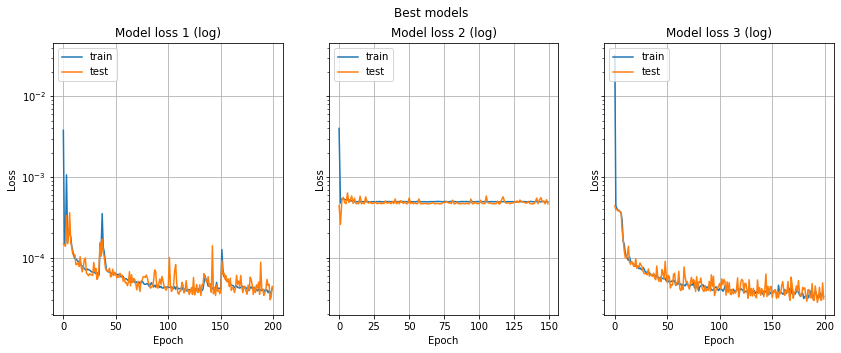

In [79]:
fig, axs = plt.subplots(1, len(models), figsize=(14,5), sharey='row')
fig.suptitle('Best models')
titles = []
for k in range(len(models)):
    titles.append(f"Model loss {k+1} (log)")
    axs[k].plot(historial[k].history['loss'])
    axs[k].plot(historial[k].history['val_loss'])
#     print(titles[-1])
    axs[k].set_title(titles[-1])
    axs[k].set_yscale("log")
    axs[k].legend(['train', 'test'], loc='upper left')
    axs[k].grid()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')
plt.show()

### Gráficas de comparación

In [96]:
Y_pred1 = models[0].predict(X)
Y_pred2 = models[1].predict(X)
Y_pred3 = models[2].predict(X)

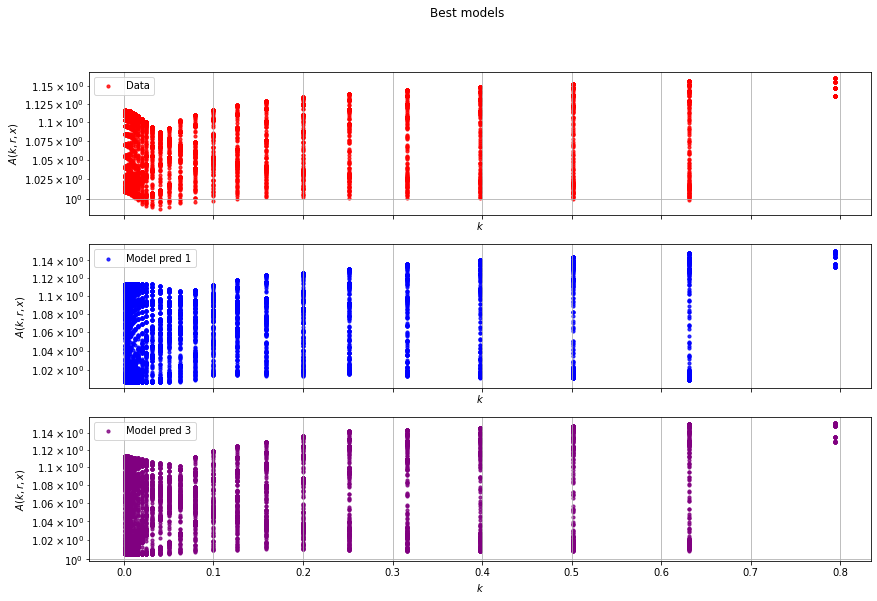

In [97]:
fig, axs = plt.subplots(len(models), figsize=(14,9), sharex="col")
fig.suptitle('Best models')

axs[0].scatter(X[:,0], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,0], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,0], Y_pred3, s=1e1, alpha=0.8, c='purple', label="Model pred 3")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

# axs[3].scatter(X[:,0], Y_pred3, s=1e1, alpha=0.8, c='green', label="Model pred 3")
# axs[3].set_yscale("log"); axs[3].grid(); axs[3].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$k$', ylabel='$A(k,r,x)$')
plt.show()

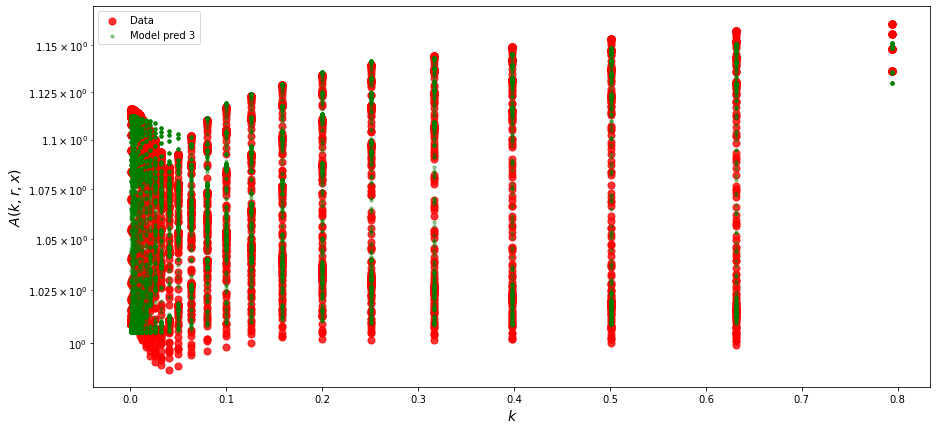

In [103]:
plt.figure(figsize=(15,7))
plt.scatter(X[:,0], Y, s=5e1, alpha=0.8, c='red', label="Data")
# plt.scatter(X[:,0], Y_pred1, s=1e1, alpha=0.4, c='blue', label="Model pred 1")
plt.scatter(X[:,0], Y_pred3, s=1e1, alpha=0.4, c='green', label="Model pred 3")
plt.xlabel('$k$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend()
plt.show()

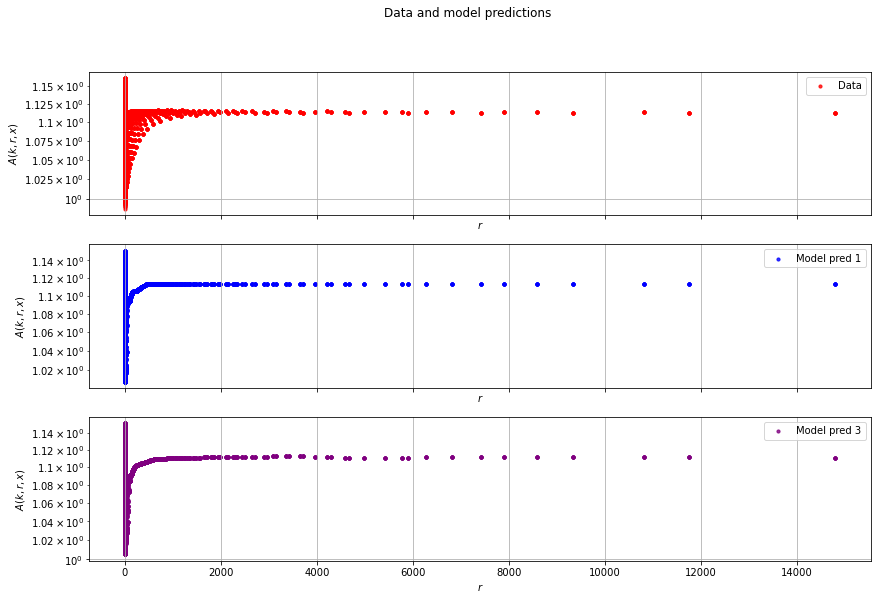

In [105]:
fig, axs = plt.subplots(len(models), figsize=(14,9), sharex="col")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,1], Y, s=1e1, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,1], Y_pred1, s=1e1, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,1], Y_pred3, s=1e1, alpha=0.8, c='purple', label="Model pred 3")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$r$', ylabel='$A(k,r,x)$')
plt.show()

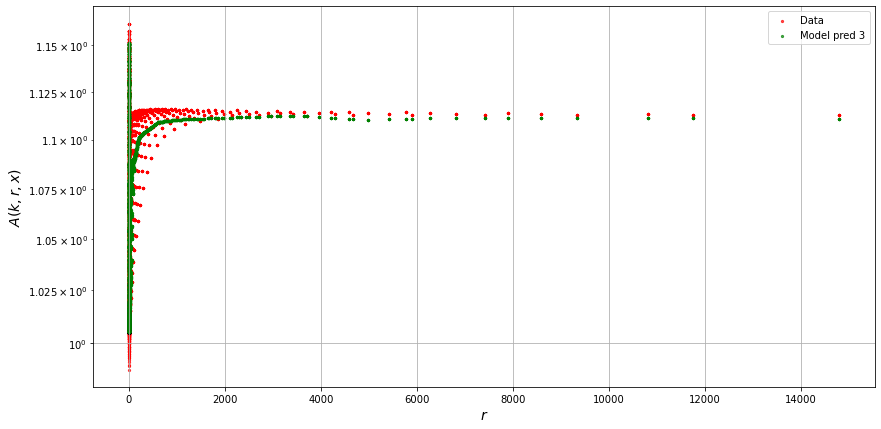

In [107]:
plt.figure(figsize=(14,7))
plt.scatter(X[:,1], Y, s=5e0, alpha=0.7, c='red', label="Data")
plt.scatter(X[:,1], Y_pred3, s=5e0, alpha=0.7, c='green', label="Model pred 3")
# plt.scatter(X[:,1], Y_pred2, s=5e0, alpha=0.7, c='blue', label="Model pred 2")
plt.xlabel('$r$', fontsize=14); plt.ylabel(r'$A(k,r,x)$', fontsize=14)
plt.yscale('log'); plt.legend(); plt.grid();
plt.show()

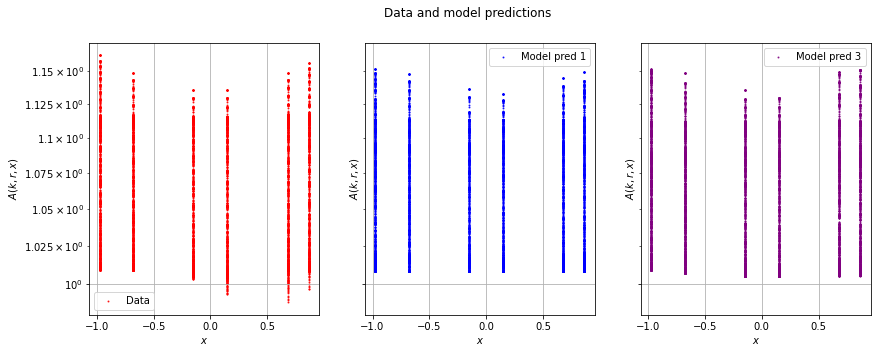

In [108]:
fig, axs = plt.subplots(1,len(models), figsize=(14,5), sharey="row")
fig.suptitle('Data and model predictions')

axs[0].scatter(X[:,2], Y, s=1e0, alpha=0.8, c='red', label="Data")
axs[0].set_yscale("log"); axs[0].grid(); axs[0].legend()

axs[1].scatter(X[:,2], Y_pred1, s=1e0, alpha=0.8, c='blue', label="Model pred 1")
axs[1].set_yscale("log"); axs[1].grid(); axs[1].legend()

axs[2].scatter(X[:,2], Y_pred3, s=1e0, alpha=0.8, c='purple', label="Model pred 3")
axs[2].set_yscale("log"); axs[2].grid(); axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel=r'$x$', ylabel='$A(k,r,x)$')
plt.show()

### Comparación 3D

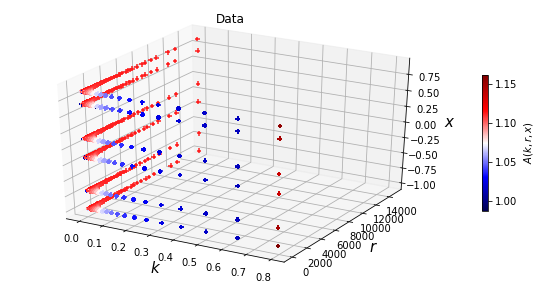

In [109]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Data")
plt.show()

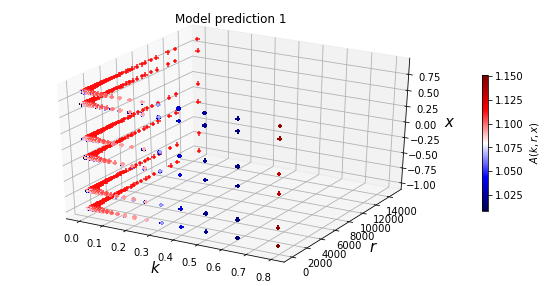

In [87]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y_pred1, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Model prediction 1")
plt.show()

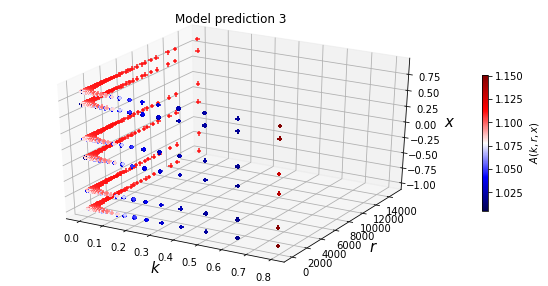

In [110]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], marker='+', c=Y_pred3, cmap='seismic', alpha=1)
ax.set_xlabel('$k$', fontsize=15)
ax.set_ylabel('$r$', fontsize=15)
ax.set_zlabel('$x$', fontsize=15)
plt.colorbar(p, shrink=0.5, label='$A(k, r, x)$'); plt.title(r"Model prediction 3")
plt.show()

### Resultado de hiperparámetros

In [89]:
import seaborn as sns

In [90]:
df

,Deep size,Num units,Learning rate,Batch size,Epochs,Error,Tiempo de ejecución
0,12,12,0.0032,4,200,0.000029,2609.403052
1,12,16,0.0056,2,150,0.000032,3847.721191
2,16,12,0.0016,16,200,0.000035,851.532308
3,12,16,0.0064,8,150,0.000035,1029.011488
4,16,12,0.0040,2,100,0.000036,2668.748719
...,...,...,...,...,...,...,...
185,16,4,0.0048,2,50,10000.000000,1431.398667
186,16,4,0.0016,2,50,10000.000000,1462.831445
187,16,8,0.0024,2,150,10000.000000,1466.344481
188,16,12,0.0024,2,150,10000.000000,1479.154790


In [91]:
# Guarda las mejores N soluciones - (1, para k=1)
best_individuals2 = tools.selBest(population,k = 20)
deep_size2 = []
num_units2 = []
learning_rate2 = []
batch_size2 = []
epochs2 = []
t = 0

for bi in best_individuals2:
    deep_size_bits2 = BitArray(bi[0:2])
    num_units_bits2 = BitArray(bi[2:4])
    learning_rate_bits2 = BitArray(bi[4:7])
    batch_size_bits2 = BitArray(bi[7:9])
    epochs_bits2 = BitArray(bi[9:])
    t += 1 
    
    deep_size2.append( 4*(deep_size_bits2.uint + 1))
    num_units2.append( 4*(num_units_bits2.uint + 1))
    learning_rate2.append( 8*(learning_rate_bits2.uint+1)*10**(-4))
    batch_size2.append( 2**(batch_size_bits2.uint +1))
    epochs2.append( 50*(epochs_bits2.uint +1))
#     print('k=',t,'\nDeep Size: ', best_deep_size2[-1], ', Num of Units: ', best_num_units2[-1], ', Learning rate: ', best_learning_rate2[-1])
#     print('Batch Size: ', best_batch_size2[-1], ", Num of Epochs: ", best_epochs2[-1])

In [119]:

best_genes.iloc[0]

Deep size                12.000000
Num units                12.000000
Learning rate             0.003200
Batch size                4.000000
Epochs                  200.000000
Error                     0.000029
Tiempo de ejecución    2609.403052
Name: 0, dtype: float64

In [124]:
# fig, axs = plt.subplots(1,2, figsize=(15,5))

# fig.suptitle('Última generación de hipermarámetros obtenidos')

# # axs[0].plot(df.iloc[:,0], df.iloc[:,1], alpha=0.5, c='blue', label="Model pred 1")
# axs[0].scatter(df.iloc[:,0], df.iloc[:,1], s=20, alpha=0.3, c='red', label="Model pred 1")
# axs[0].scatter(best_genes.iloc[:,0], best_genes.iloc[:,1], s=80, alpha=1, c='red', label="Mejores individuos")
# axs[0].grid(); axs[0].legend()
# # axs[0].legend(loc='upper right'); 
# # axs[0].set_xlim([2, 18]); axs[0].set_ylim([1, 65])
# axs[0].set(xlabel=r'Deep size', ylabel='Num units')

# # axs[1].plot(df.iloc[:,2], df.iloc[:,3], alpha=0.5, c='blue', label="Model pred 1")
# axs[1].scatter(df.iloc[:,2], df.iloc[:,3], s=20, alpha=0.3, c='red', label="Model pred 1")
# axs[1].scatter(best_genes.iloc[:,2], best_genes.iloc[:,3], s=80, alpha=1, c='red', label="Mejores individuos")
# axs[1].set_yscale("log"); 
# axs[1].grid(); axs[1].legend(loc='upper right')
# # axs[1].set_xlim([1e-4, 31e-4]); axs[1].set_ylim([2**1, 2**4])
# axs[1].set(xlabel=r'Learning rate', ylabel='Batch size')

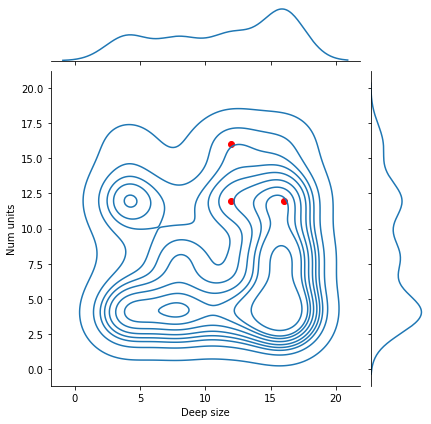

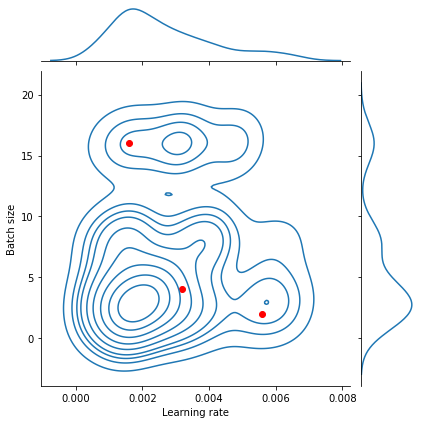

In [126]:
g1= sns.jointplot(data=df, x="Deep size", y="Num units", kind="kde")
g1.ax_joint.scatter(best_genes.iloc[:,0], best_genes.iloc[:,1], color = 'red', label="a")

plt.show()

g2= sns.jointplot(x=df.iloc[:,2], y=df.iloc[:,3], kind='kde')
g2.ax_joint.scatter(best_genes.iloc[:,2], best_genes.iloc[:,3], color = 'red', label="a")

plt.show()